# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [64]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Imports

In [66]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from darts import TimeSeries

%matplotlib inline

## 2. Load Dataset

In [67]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Sri_Lanka_Dengue_Cases_and_Weather_Data_updated.csv")

In [68]:
df.head()

District  Number_of_Cases Week_Start_Date  Year  Month  Week Week_End_Date  \
0   Ampara                0      2007-01-01  2007      1     1    2007-01-08   
1   Ampara                0      2007-01-08  2007      1     2    2007-01-15   
2   Ampara                0      2007-01-15  2007      1     3    2007-01-22   
3   Ampara                0      2007-01-22  2007      1     4    2007-01-29   
4   Ampara                0      2007-01-29  2007      1     5    2007-02-05   

   Avg Max Temp (°C)  Avg Min Temp (°C)  Avg Apparent Max Temp (°C)  \
0            26.9375            21.8625                     28.8500   
1            26.3500            23.3250                     30.2625   
2            27.2125            23.1625                     29.5750   
3            26.7250            23.0375                     29.9500   
4            27.3625            22.9625                     30.7500   

   Avg Apparent Min Temp (°C)  Total Precipitation (mm)  \
0                     24.1000                       8.0   
1                     26.7000                      86.1   
2                     25.9625                       3.1   
3                     26.1125                      53.6   
4                     26.1250                       8.2   

   Avg Wind Speed (km/h)  Max Wind Gusts (km/h)  Avg Daylight Duration (hours)  
0                18.2000                   44.3                      11.714583  
1                17.0250                   43.6                      11.733333  
2                20.1875                   48.2                      11.754167  
3                17.2000                   42.5                      11.783333  
4                17.2625                   40.0                      11.812500

In [69]:
len(df)

23250

In [70]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [71]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


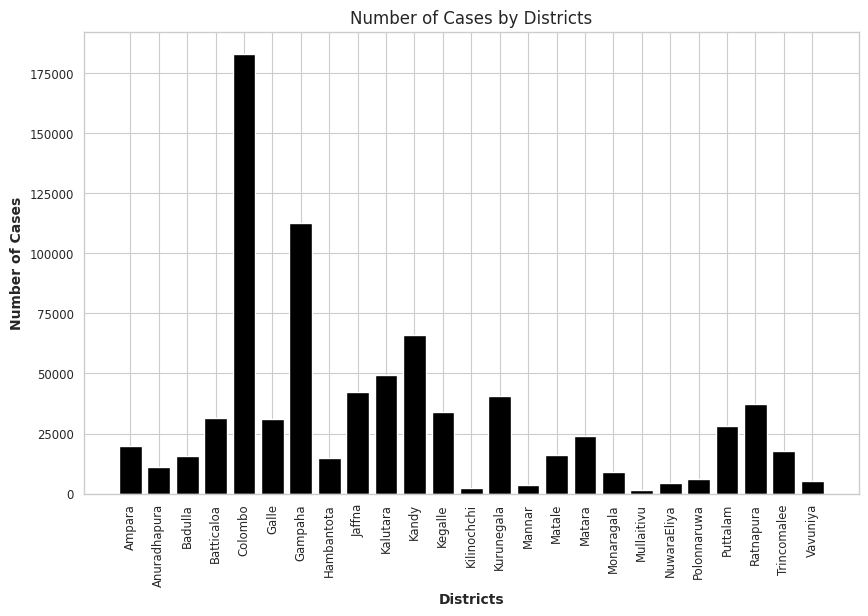

In [72]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Number_of_Cases_by_Districts.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [73]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [74]:
df.head()

District  Number_of_Cases Week_Start_Date  Year  Month  Week Week_End_Date  \
0   Ampara                0      2007-01-01  2007      1     1    2007-01-08   
1   Ampara                0      2007-01-08  2007      1     2    2007-01-15   
2   Ampara                0      2007-01-15  2007      1     3    2007-01-22   
3   Ampara                0      2007-01-22  2007      1     4    2007-01-29   
4   Ampara                0      2007-01-29  2007      1     5    2007-02-05   

   Avg Max Temp (°C)  Avg Min Temp (°C)  Avg Apparent Max Temp (°C)  \
0            26.9375            21.8625                     28.8500   
1            26.3500            23.3250                     30.2625   
2            27.2125            23.1625                     29.5750   
3            26.7250            23.0375                     29.9500   
4            27.3625            22.9625                     30.7500   

   Avg Apparent Min Temp (°C)  Total Precipitation (mm)  \
0                     24.1000                       8.0   
1                     26.7000                      86.1   
2                     25.9625                       3.1   
3                     26.1125                      53.6   
4                     26.1250                       8.2   

   Avg Wind Speed (km/h)  Max Wind Gusts (km/h)  Avg Daylight Duration (hours)  
0                18.2000                   44.3                      11.714583  
1                17.0250                   43.6                      11.733333  
2                20.1875                   48.2                      11.754167  
3                17.2000                   42.5                      11.783333  
4                17.2625                   40.0                      11.812500

## 5. Modelling
### Hyperparameter

In [75]:
%pip install "u8darts[all]"

In [76]:
from darts.models import ARIMA, AutoARIMA, VARIMA, ExponentialSmoothing, FourTheta, Prophet, FFT, KalmanForecaster, CatBoostModel, RandomForest, LinearRegressionModel
from darts.metrics import rmse, mae, smape, r2_score, rmsle

In [77]:
# Models
ampara_model = FFT()
anuradhapura_model = KalmanForecaster()
badulla_model = CatBoostModel(lags=[-1, -2, -3, -13, -26, -52, -104], output_chunk_length=12, random_state=42)
batticaloa_model = ExponentialSmoothing()
colombo_model = RandomForest(lags=[-1, -2, -3, -13, -26, -52, -104], output_chunk_length=12, random_state=42)
galle_model = FFT()
gampaha_model = RandomForest(lags=[-1, -2, -3, -13, -26, -52, -104], output_chunk_length=12,random_state=42)
hambantota_model = RandomForest(lags=[-1, -2, -3, -13, -26, -52, -104], lags_future_covariates=[-1, -2, -3, -13, -26, -52], output_chunk_length=12,random_state=42)
jaffna_model = ARIMA()
kalutara_model = RandomForest(lags=[-1, -2, -3, -13, -26, -52, -104], output_chunk_length=12,random_state=42)
kandy_model = ARIMA()
kegalle_model = LinearRegressionModel(
    lags=[-1, -2, -3, -13, -26, -52],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
kilinochchi_model = ExponentialSmoothing()
kurunegala_model = CatBoostModel(
    lags=[-1, -2, -3, -13, -26, -52, -104],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
mannar_model = AutoARIMA()
matale_model = RandomForest(lags=[-1, -2, -3, -13, -26, -52, -104], lags_future_covariates=[-1, -2, -3, -13, -26, -52], output_chunk_length=12,random_state=42)
matara_model = AutoARIMA()
monaragala_model = Prophet()
mullaitivu_model = AutoARIMA()
nuwaraEliya_model = Prophet()
polonnaruwa_model = AutoARIMA()
puttalam_model = LinearRegressionModel(lags=[-1, -2, -3, -13, -26, -52], output_chunk_length=12, random_state=42)
ratnapura_model = AutoARIMA()
trincomalee_model = Prophet()
vavuniya_model = KalmanForecaster()

In [78]:
district_models = [
    ampara_model, anuradhapura_model, badulla_model, batticaloa_model,
    colombo_model, galle_model, gampaha_model, hambantota_model,
    jaffna_model, kalutara_model, kandy_model, kegalle_model,
    kilinochchi_model, kurunegala_model, mannar_model, matale_model,
    matara_model, monaragala_model, mullaitivu_model, nuwaraEliya_model,
    polonnaruwa_model, puttalam_model, ratnapura_model, trincomalee_model,
    vavuniya_model
]

In [79]:
# Function to plot training and validation series
def plot_train_val_forecasted_series(train_series, val_series, forecasted_series, district_name):
    plt.figure(figsize=(16, 8))  # Larger figure for improved clarity
    sns.set_style("whitegrid")   # Add a clean grid background

    # Extract years for the grid
    all_data = pd.concat([train_series, val_series])  # Combine both series for consistent ticks
    year_ticks = all_data.index.to_period("Y").drop_duplicates().to_timestamp()

    # Plot training series
    plt.plot(train_series, label='Training Data', color='blue', linewidth=2)

    # Plot validation series
    plt.plot(val_series, label='Validation Data', color='green', linewidth=2)

    # Plot validation series
    plt.plot(forecasted_series, label='Forecasted Data', color='orange', linewidth=2)

    # Add title and labels
    plt.title(f"Historical Data with Forecasted Data for {district_name}", fontsize=24, fontweight='bold')
    plt.xlabel("Week End Date", fontsize=20)
    plt.ylabel("Number of Cases", fontsize=20)

    # Set x-axis ticks to start of each year
    plt.xticks(year_ticks, [year.year for year in year_ticks], fontsize=16, rotation=45)
    plt.yticks(fontsize=16)

    # Add vertical gridlines for each year
    for year in year_ticks:
        plt.axvline(x=year, color='gray', linewidth=1)

    # Add a legend
    plt.legend(fontsize=18)

    fig_folder = f"/content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Historical_Data_with_Forecasted_Data_for_{district_name}.png"
    # Optional: Save the plot as a high-resolution image
    plt.savefig(fig_folder, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [80]:
# Function to plot validation and forecasted series for 12 weeks
def plot_val_forecasted_series_for_12_weeks(val_series, forecasted_series, district_name):
    plt.figure(figsize=(18, 10))  # Large figure for improved clarity
    sns.set_style("whitegrid")   # Add a clean grid background

    # Ensure only the last 12 weeks are plotted
    val_series_12 = val_series.tail(12)
    forecasted_series_12 = forecasted_series.tail(12)

    # Extract years for the grid (optional if limited to 12 weeks)
    all_data = pd.concat([val_series_12, forecasted_series_12])
    year_ticks = all_data.index.to_period("Y").drop_duplicates().to_timestamp()

    # Plot validation series
    plt.plot(val_series_12, label='Validation Data', color='green', linewidth=2)

    # Plot forecasted series
    plt.plot(forecasted_series_12, label='Forecasted Data', color='orange', linewidth=2, linestyle='--')

    # Add title and labels
    plt.title(f"Validation vs Forecasted Data (Last 12 Weeks) for {district_name}", fontsize=20, fontweight='bold')
    plt.xlabel("Week End Date", fontsize=16)
    plt.ylabel("Number of Cases", fontsize=16)

    # Customize ticks
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    # Add vertical gridlines for clarity
    plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

    # Add a legend
    plt.legend(fontsize=14)

    fig_folder = f"/content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Validation_vs_Forecasted_Data_(Last 12 Weeks)_for_{district_name}.png"
    # Save the plot as a high-resolution image
    plt.savefig(fig_folder, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [81]:
def save_model(model, model_name, district_name, folder):
    # Create directory if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Define the model file path
    model_file = os.path.join(folder, f'{district_name}_{model_name}.pkl')

    # Save the model using pickle
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved for {district_name}: {model_file}")

In [82]:
def train_and_forecast(train_series, test_series, future_covariates, model, district_name):
    model_folder = "/content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/"
    model_name = type(model).__name__

    # Districts without covariates
    without_covariates = [
        "Ampara", "Badulla", "Batticaloa", "Colombo", "Galle", "Gampaha", "Jaffna", "Kalutara",  "Kandy", "Kilinochchi", "Mannar",
        "Matara", "Monaragala", "Mullaitivu", "NuwaraEliya", "Polonnaruwa", "Puttalam",
        "Ratnapura", "Trincomalee", "Vavuniya"
    ]

    # Districts with covariates
    with_covariates = [
        "Anuradhapura", "Hambantota", "Kegalle",
        "Kurunegala", "Matale",
    ]
    forecast = None
    if district_name in without_covariates:
      model.fit(train_series)
      # Forecast for the next 12 weeks
      forecast = model.predict(n=len(test_series))

    elif district_name in with_covariates:
      model.fit(train_series, future_covariates=future_covariates)
      # Forecast for the next 12 weeks
      forecast = model.predict(n=len(test_series), future_covariates=future_covariates)

    # Save Model
    save_model(model, model_name, district_name, model_folder)


    # Calculate metrics
    val_values = test_series.values()
    forecast_values = forecast.values()

    # Ensure the forecast and validation values are the same length
    assert len(val_values) == len(forecast_values), "Forecast and validation series must have the same length for metrics calculation."

    train = train_series.pd_dataframe()
    val = test_series.pd_dataframe()
    predicted = forecast.pd_dataframe()

    plot_train_val_forecasted_series(train, val, predicted, district_name)
    plot_val_forecasted_series_for_12_weeks(val, predicted, district_name)

    # Compute metrics
    error_rmse = rmse(test_series, forecast)
    error_mae = mae(test_series, forecast)
    error_smape = smape(test_series, forecast)
    error_rmsle = rmsle(test_series, forecast)

    errors = {
        "RMSE": error_rmse,
        "MAE": error_mae,
        "SMAPE": error_smape,
        "RMSLE": error_rmsle
    }
    print(errors)
    results = {
        "District": district_name,
        "Model": model_name,
        "Metrics": errors
    }
    return results

<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length for Ampara: 918
Validation length for Ampara: 12
Model saved for Ampara: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Ampara_FFT.pkl


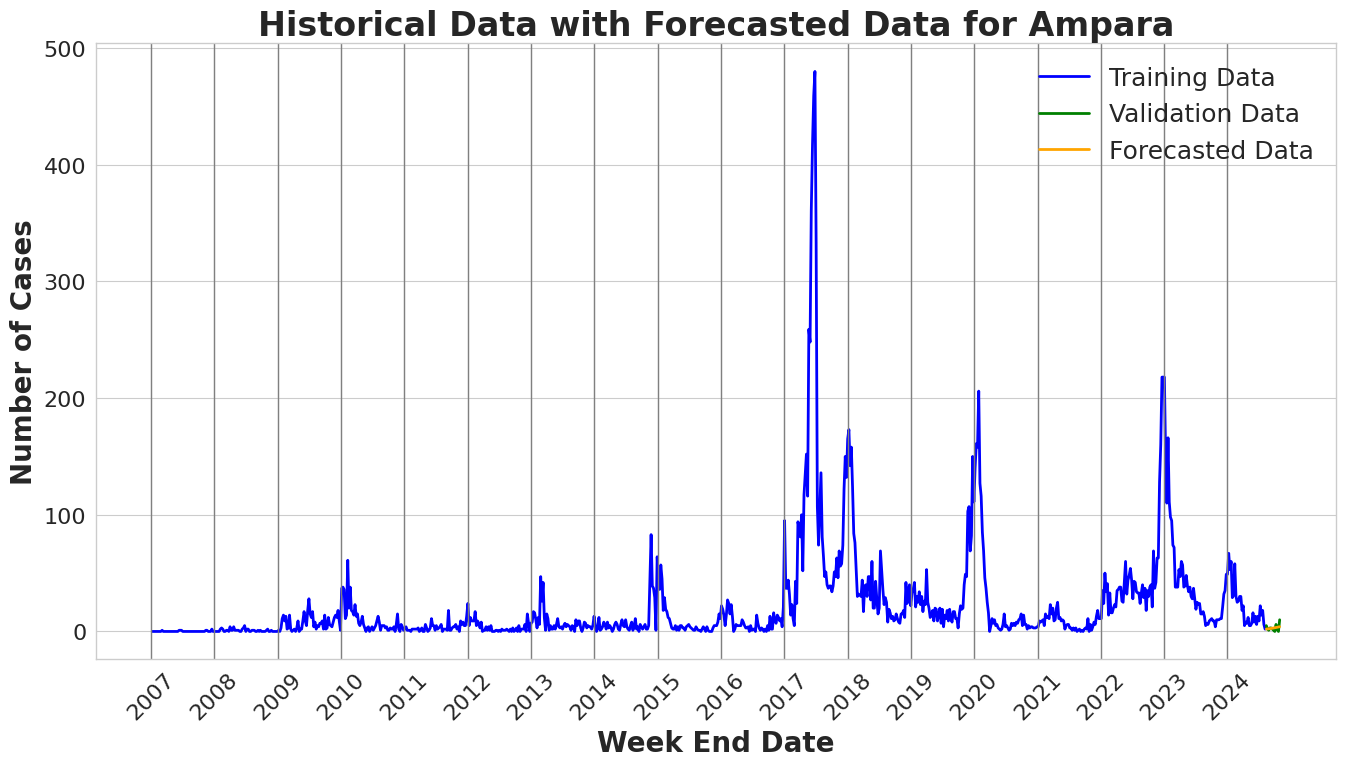

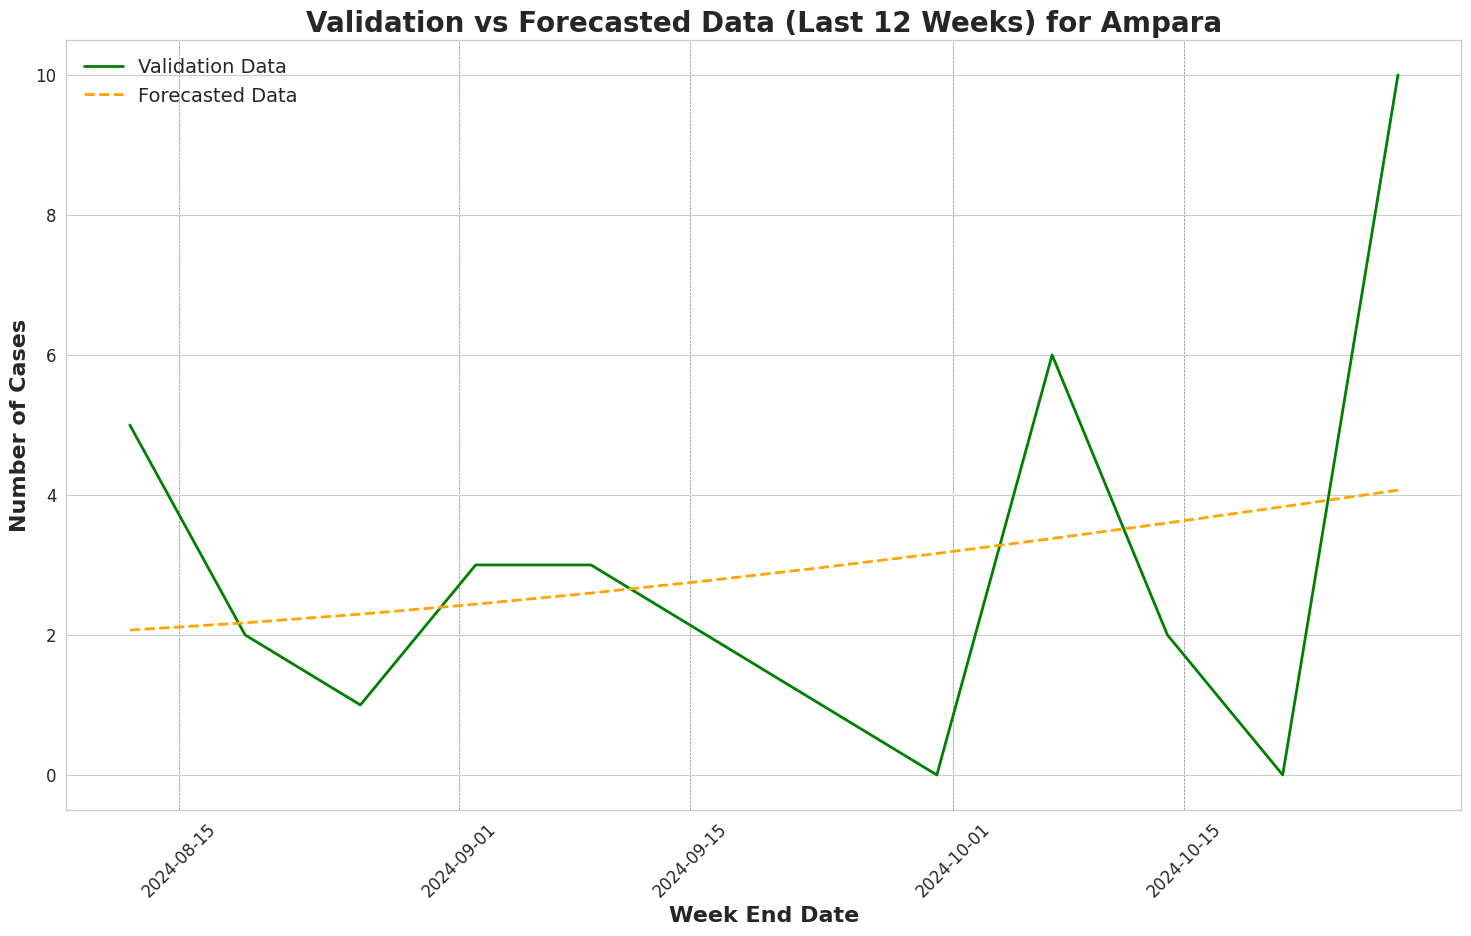

{'RMSE': 2.65408464622466, 'MAE': 2.10396994656825, 'SMAPE': 77.8087940758519, 'RMSLE': 0.7514073856517136}
Training length for Anuradhapura: 918
Validation length for Anuradhapura: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Anuradhapura: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Anuradhapura_KalmanForecaster.pkl


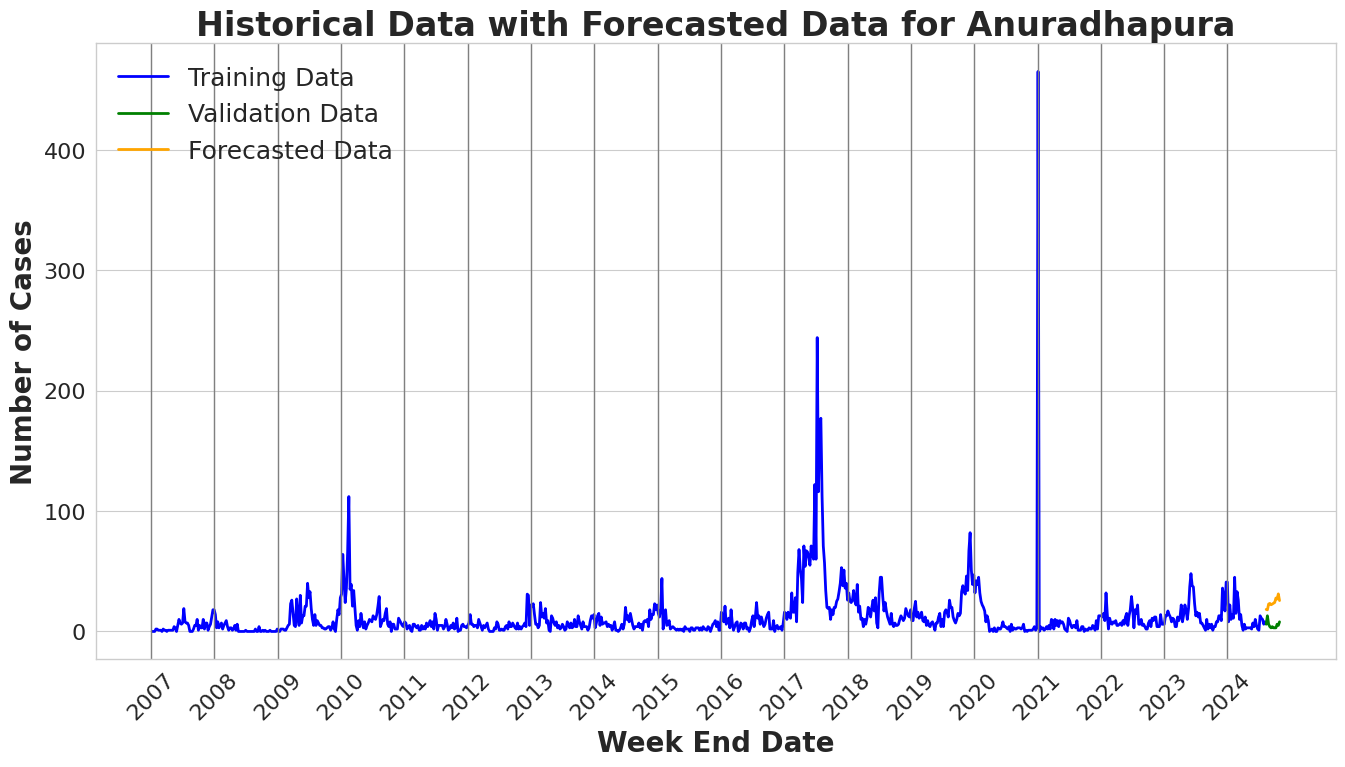

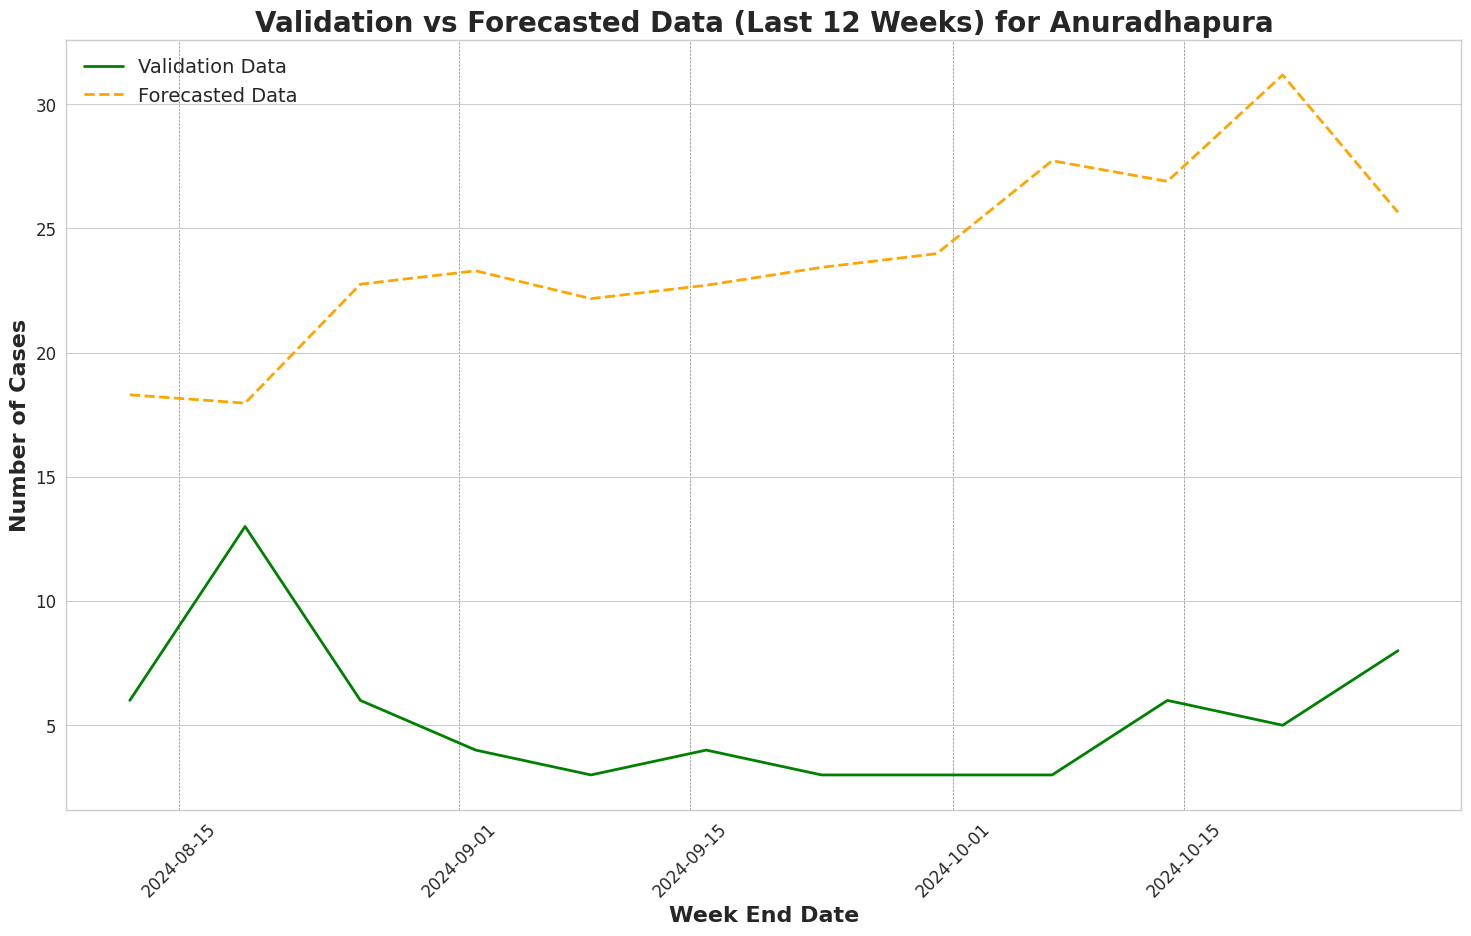

{'RMSE': 19.253041455558193, 'MAE': 18.503111855372975, 'SMAPE': 127.6109368523435, 'RMSLE': 1.5012893276747135}
Training length for Badulla: 918
Validation length for Badulla: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Badulla: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Badulla_CatBoostModel.pkl


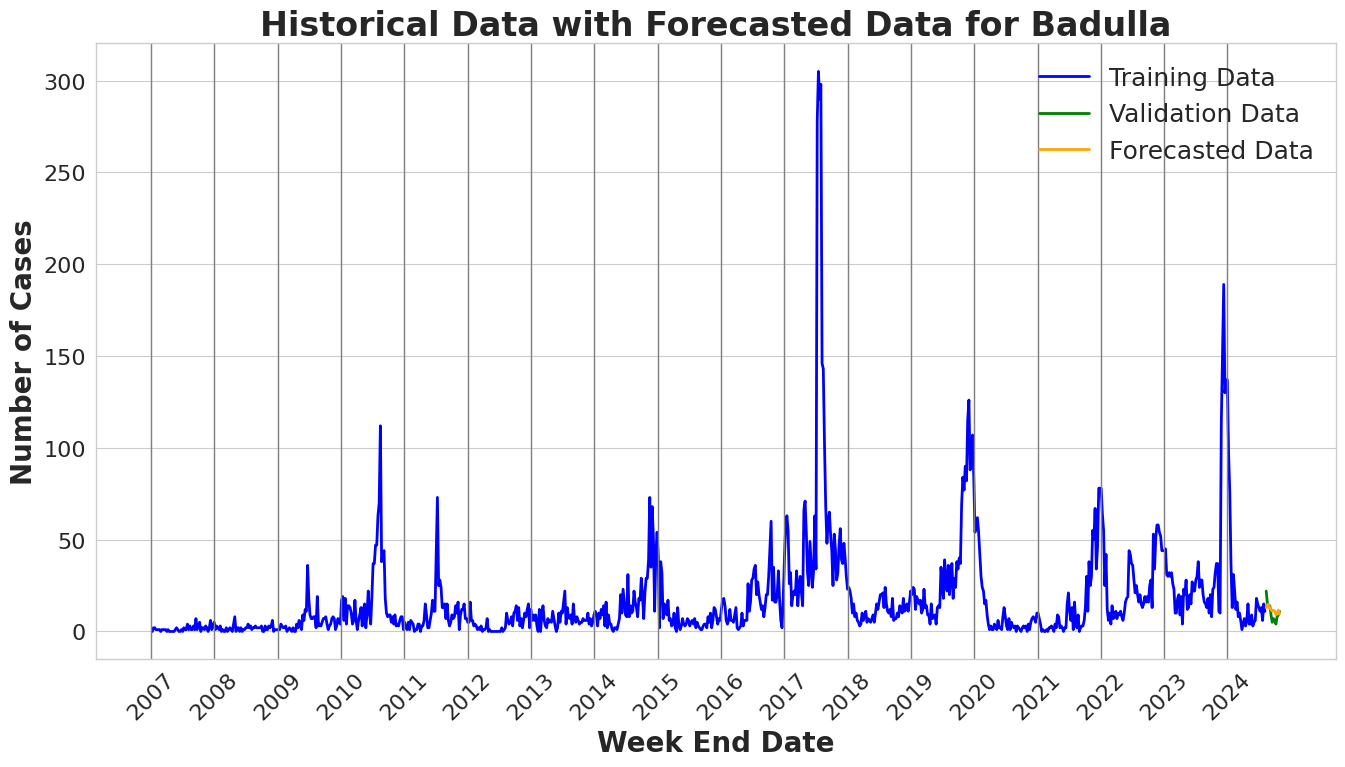

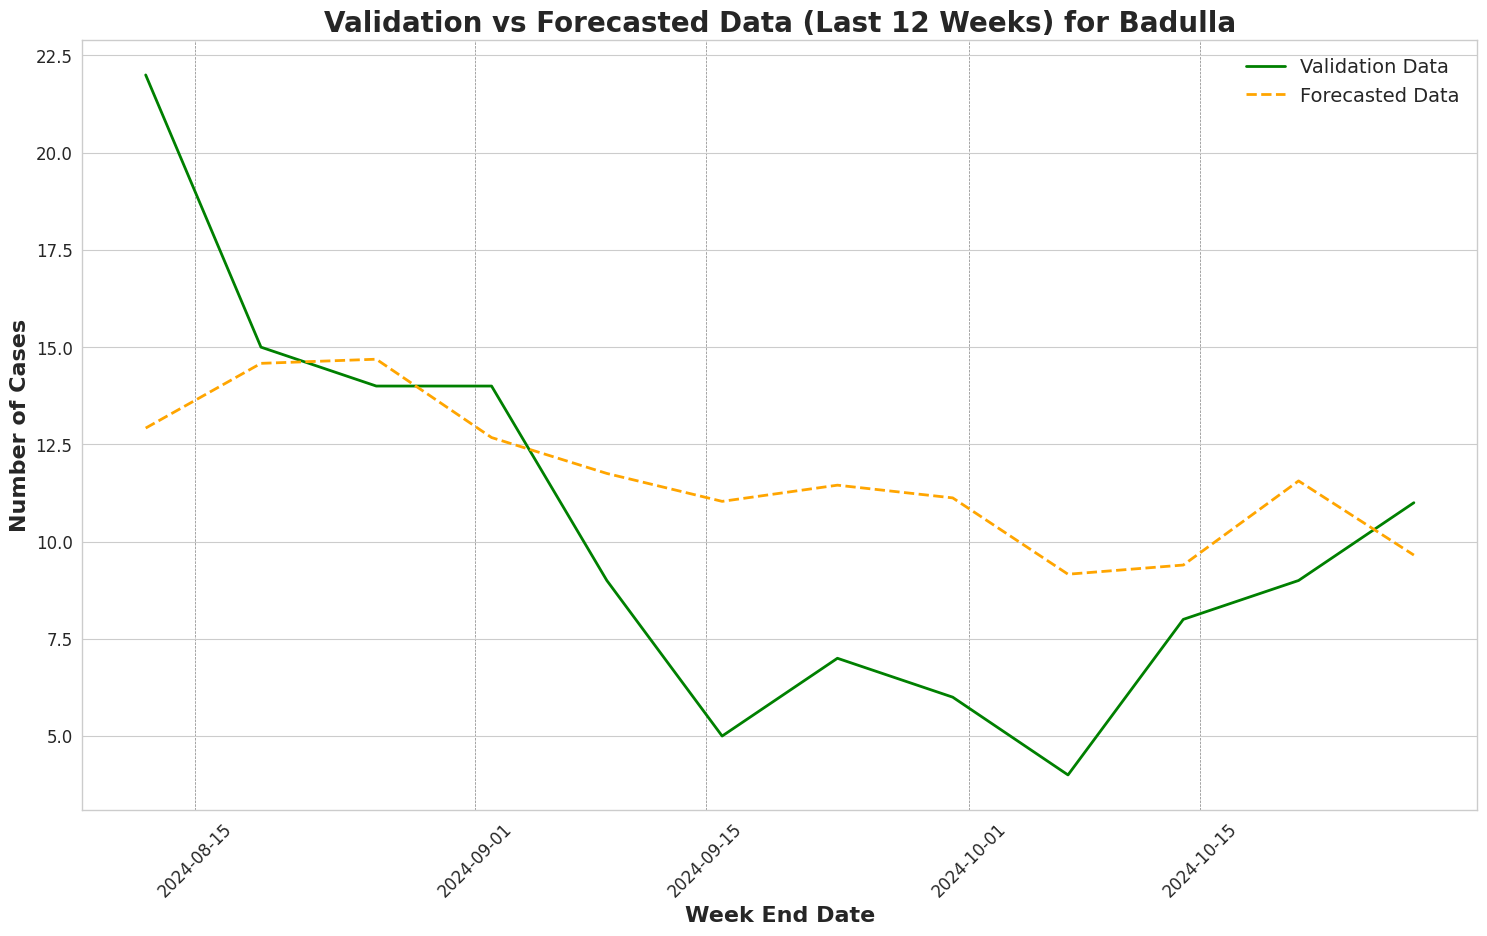

{'RMSE': 4.202087247072857, 'MAE': 3.361644589117508, 'SMAPE': 34.3249048096252, 'RMSLE': 0.3973172047882825}
Training length for Batticaloa: 918
Validation length for Batticaloa: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Batticaloa: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Batticaloa_ExponentialSmoothing.pkl


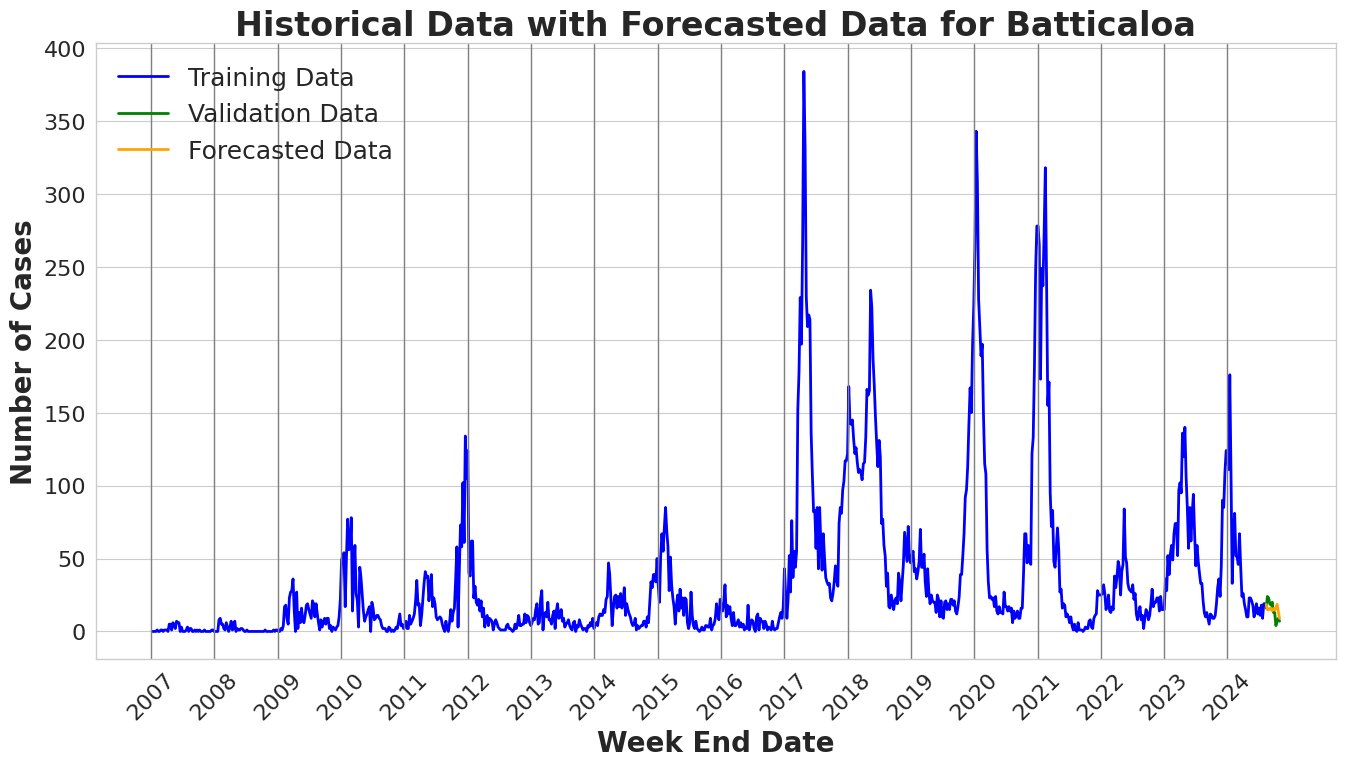

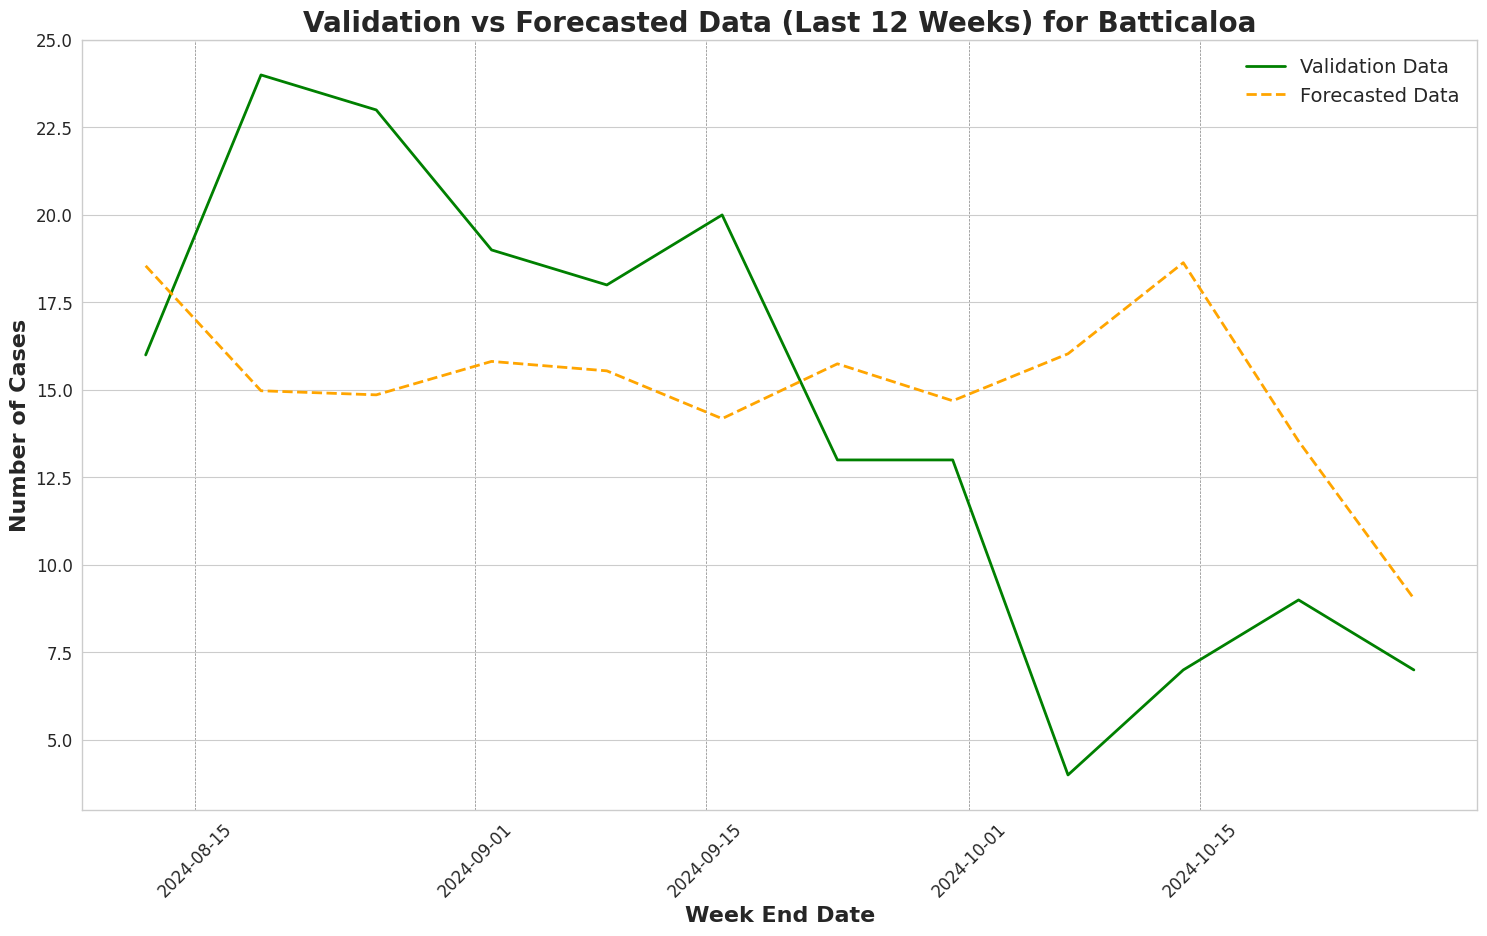

{'RMSE': 6.579609759119692, 'MAE': 5.487238043848642, 'SMAPE': 39.909278969829266, 'RMSLE': 0.5075339058566052}
Training length for Colombo: 918
Validation length for Colombo: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Colombo: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Colombo_RandomForest.pkl


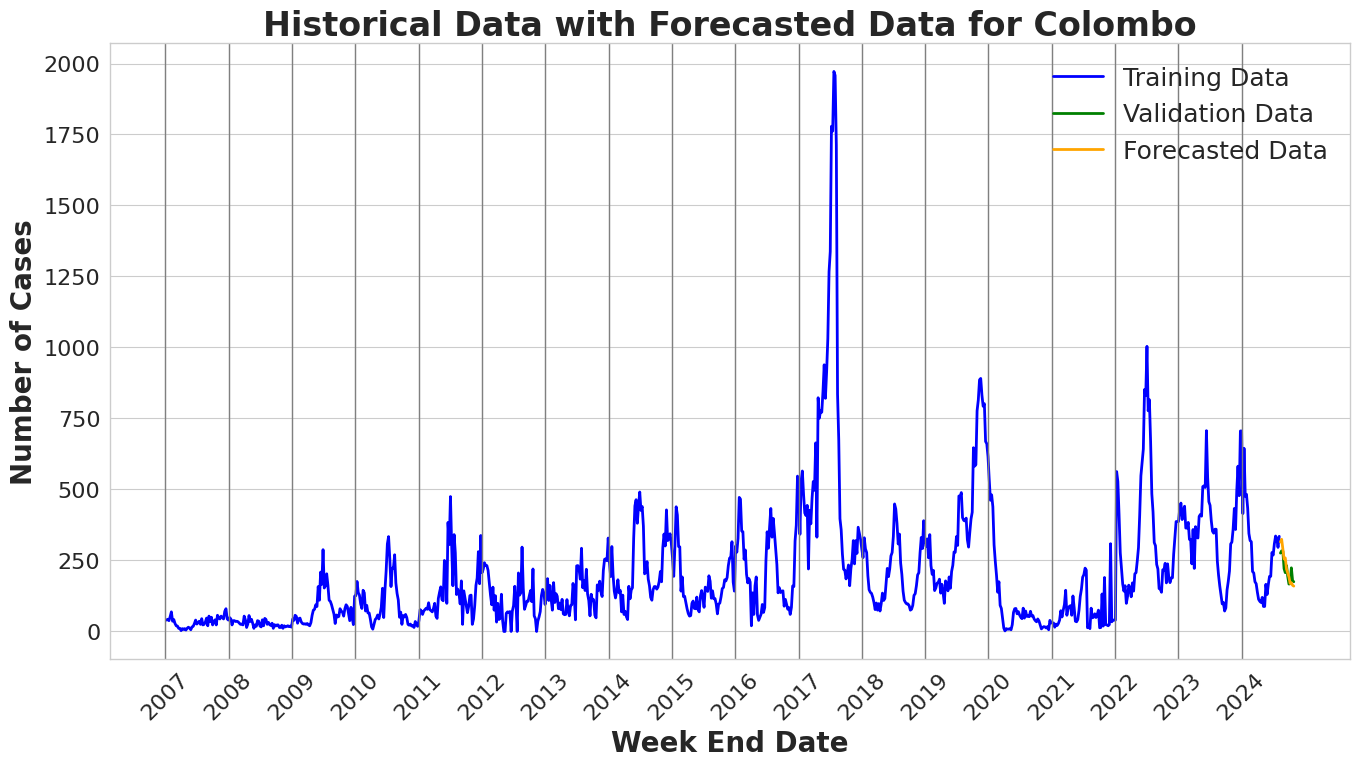

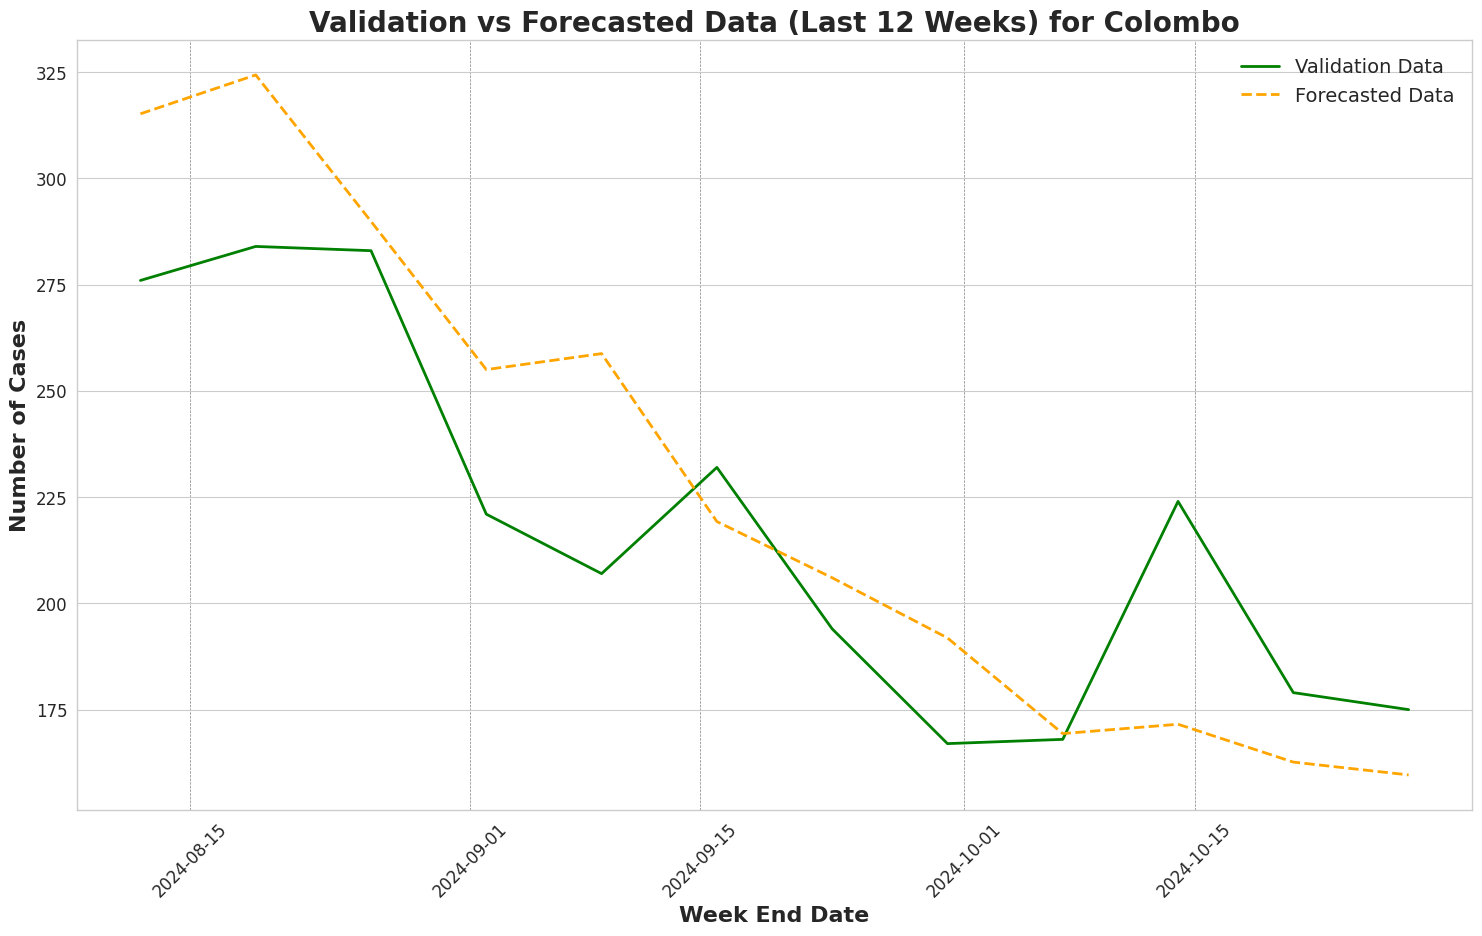

{'RMSE': 30.596024387709804, 'MAE': 25.61916666666666, 'SMAPE': 11.422327947595138, 'RMSLE': 0.1351200185058095}
Training length for Galle: 918
Validation length for Galle: 12
Model saved for Galle: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Galle_FFT.pkl


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


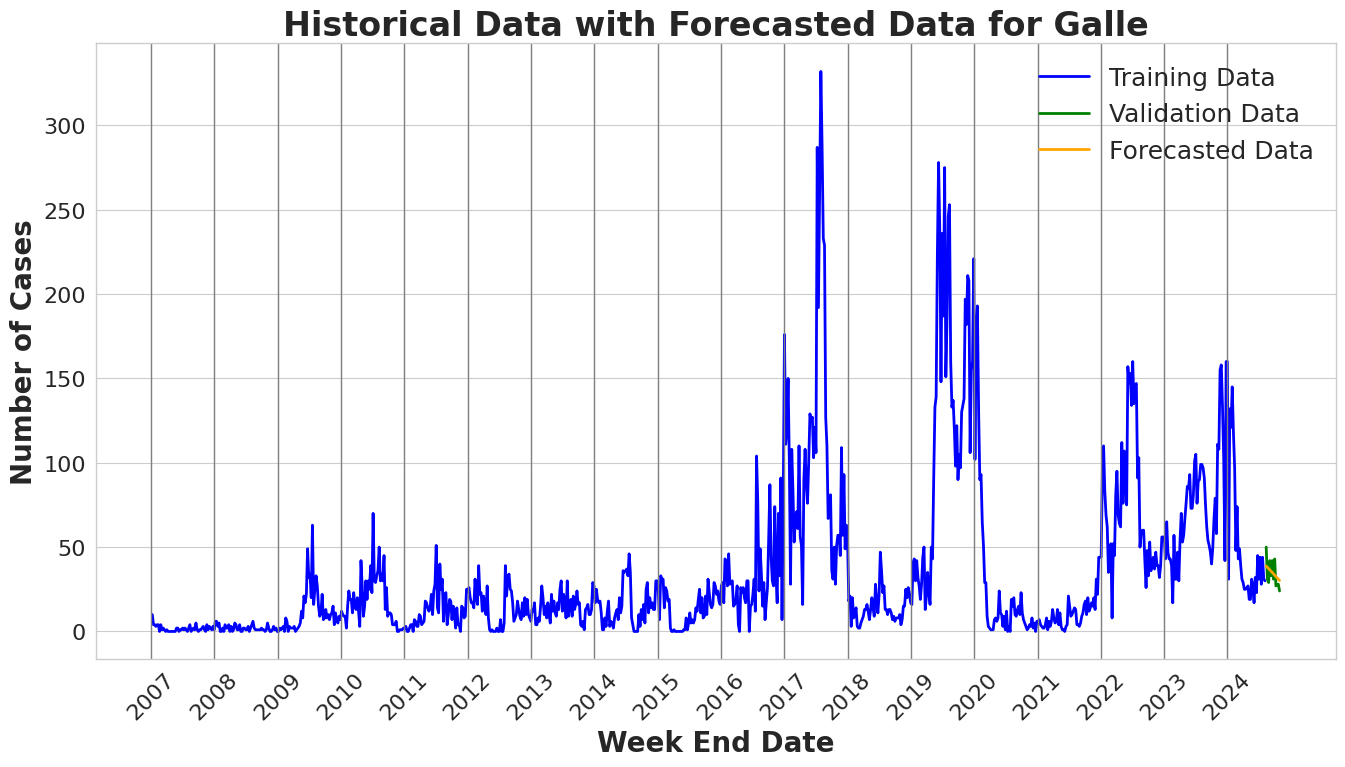

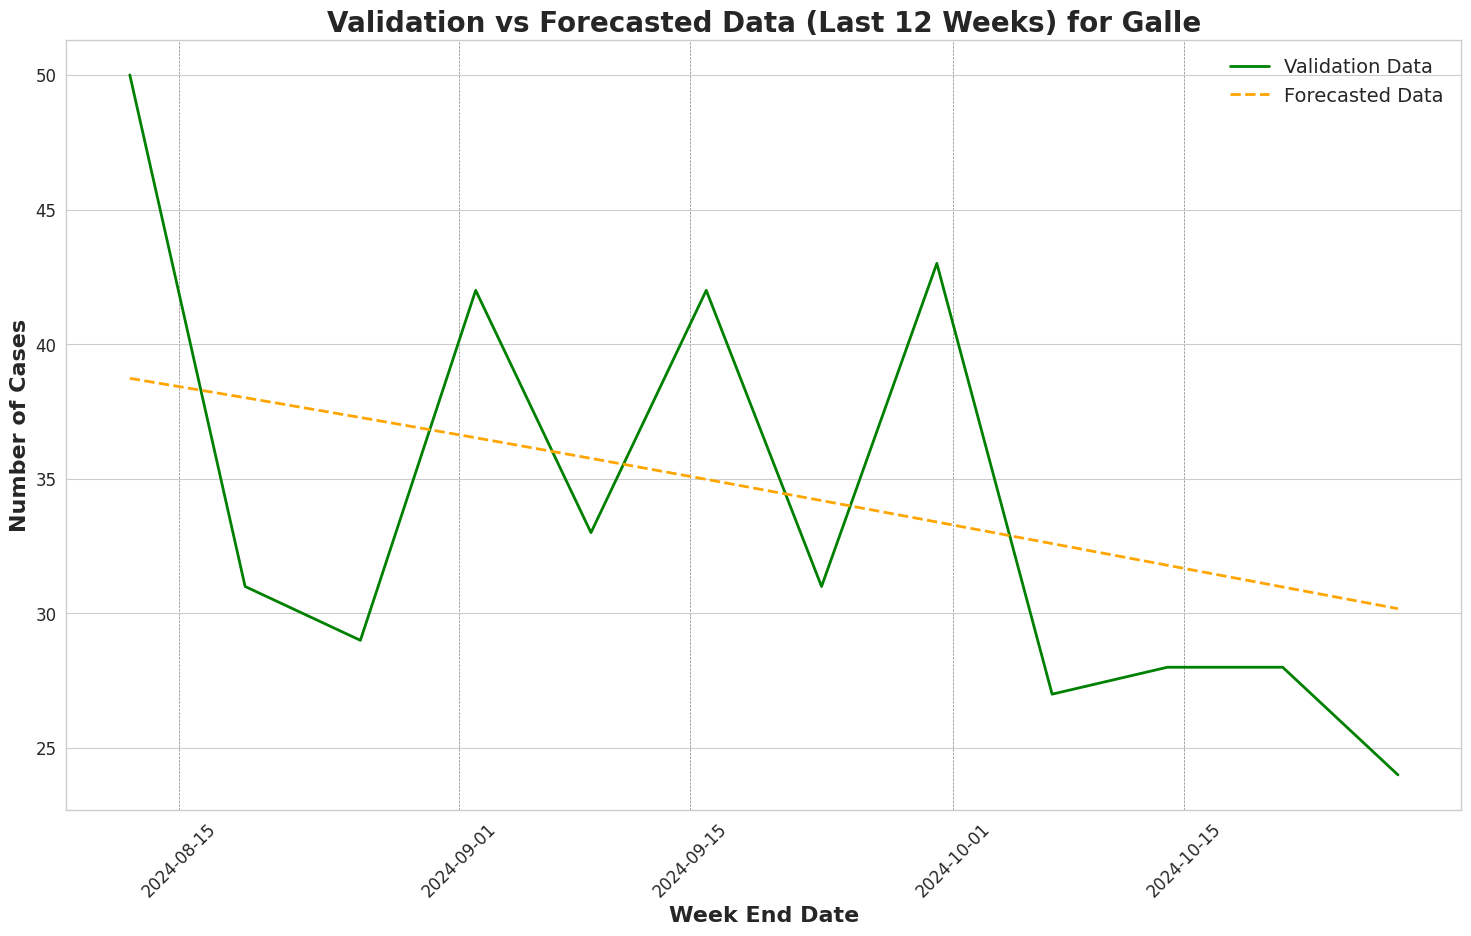

{'RMSE': 6.624701944444677, 'MAE': 6.095438305595407, 'SMAPE': 17.515767446900806, 'RMSLE': 0.18111006039225247}
Training length for Gampaha: 918
Validation length for Gampaha: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Gampaha: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Gampaha_RandomForest.pkl


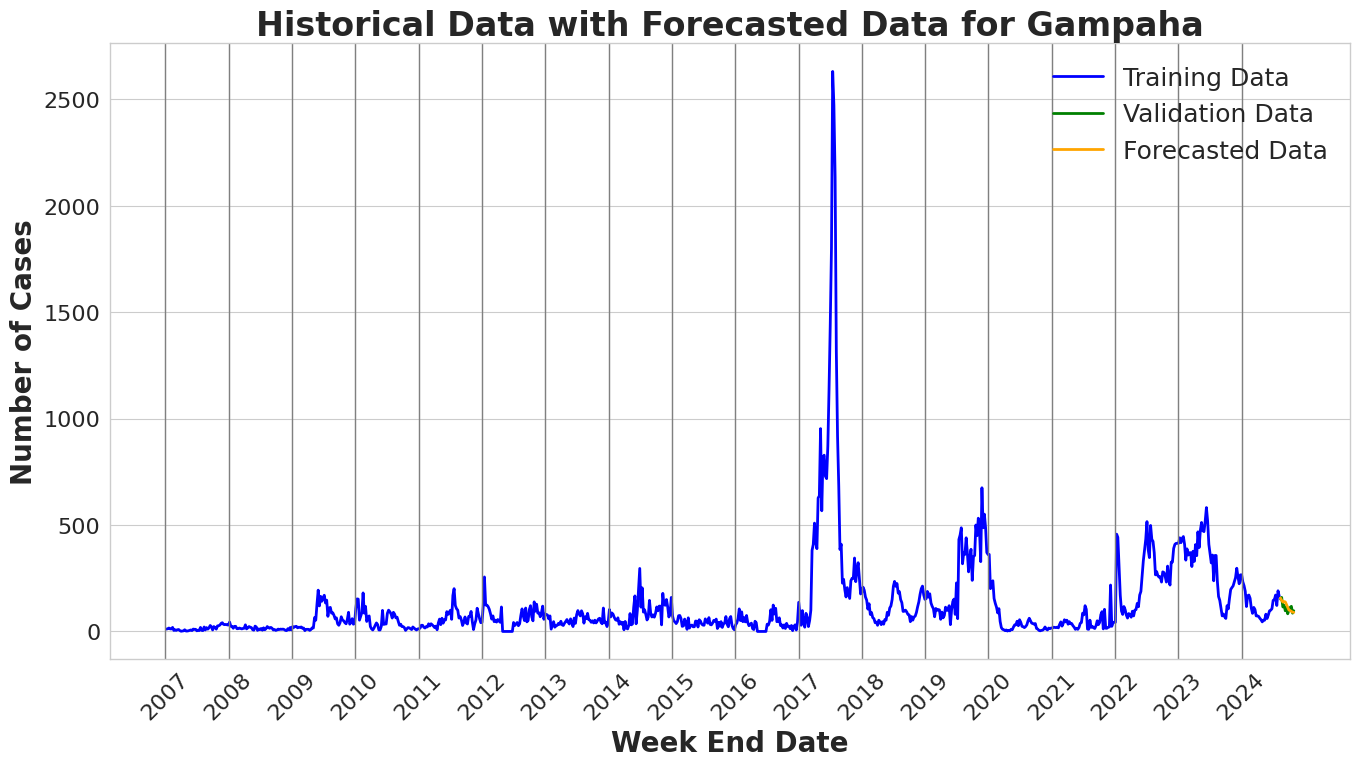

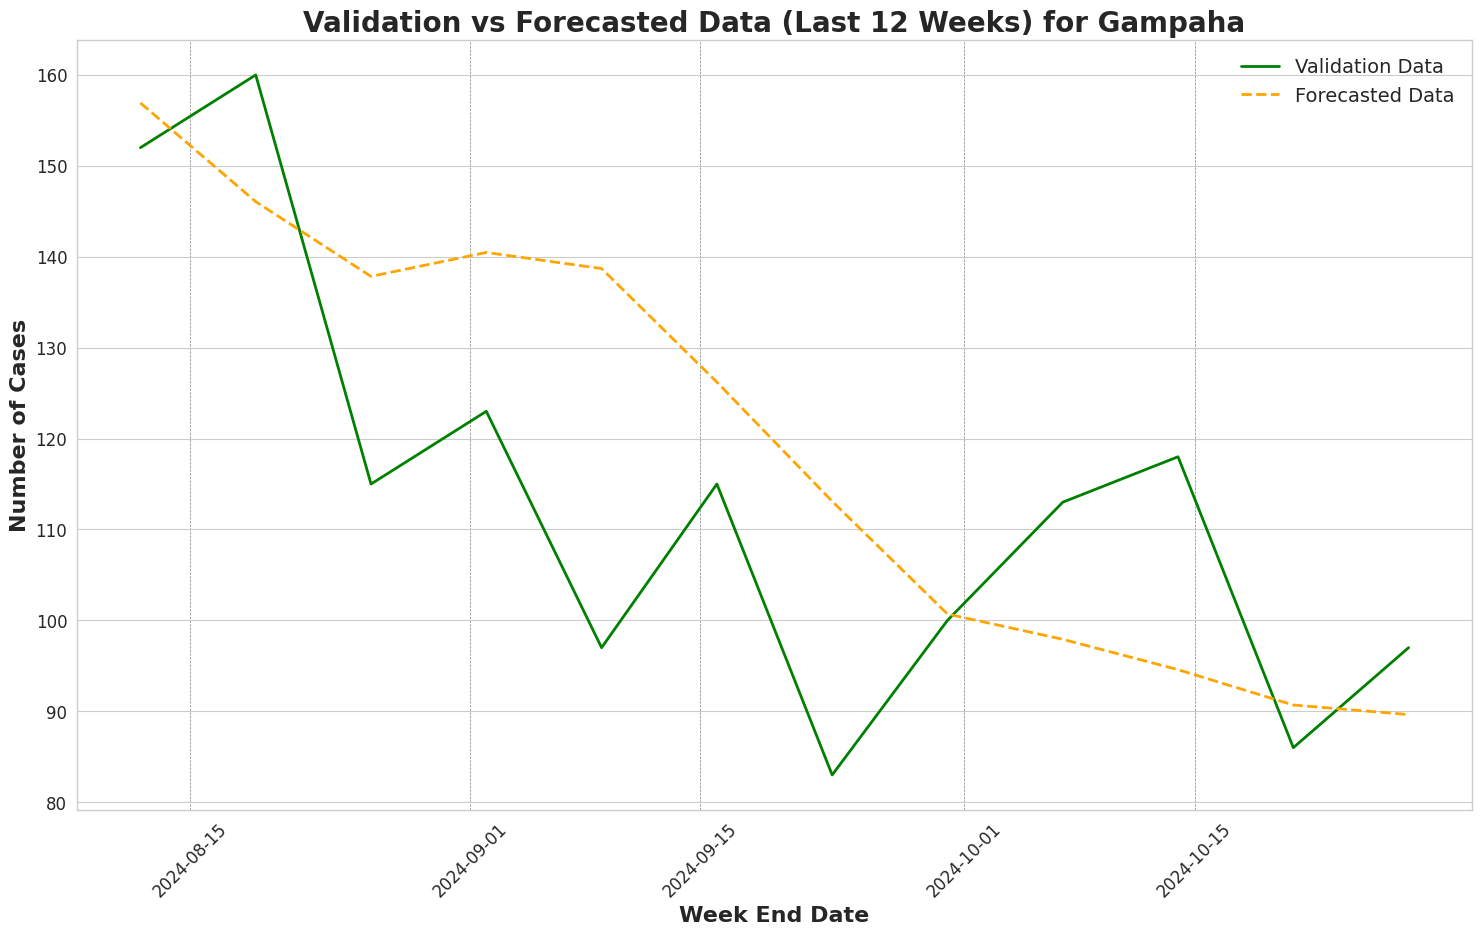

{'RMSE': 19.724179535112054, 'MAE': 16.11916666666667, 'SMAPE': 14.102224232900205, 'RMSLE': 0.17414988654231967}
Training length for Hambantota: 918
Validation length for Hambantota: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Hambantota: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Hambantota_RandomForest.pkl


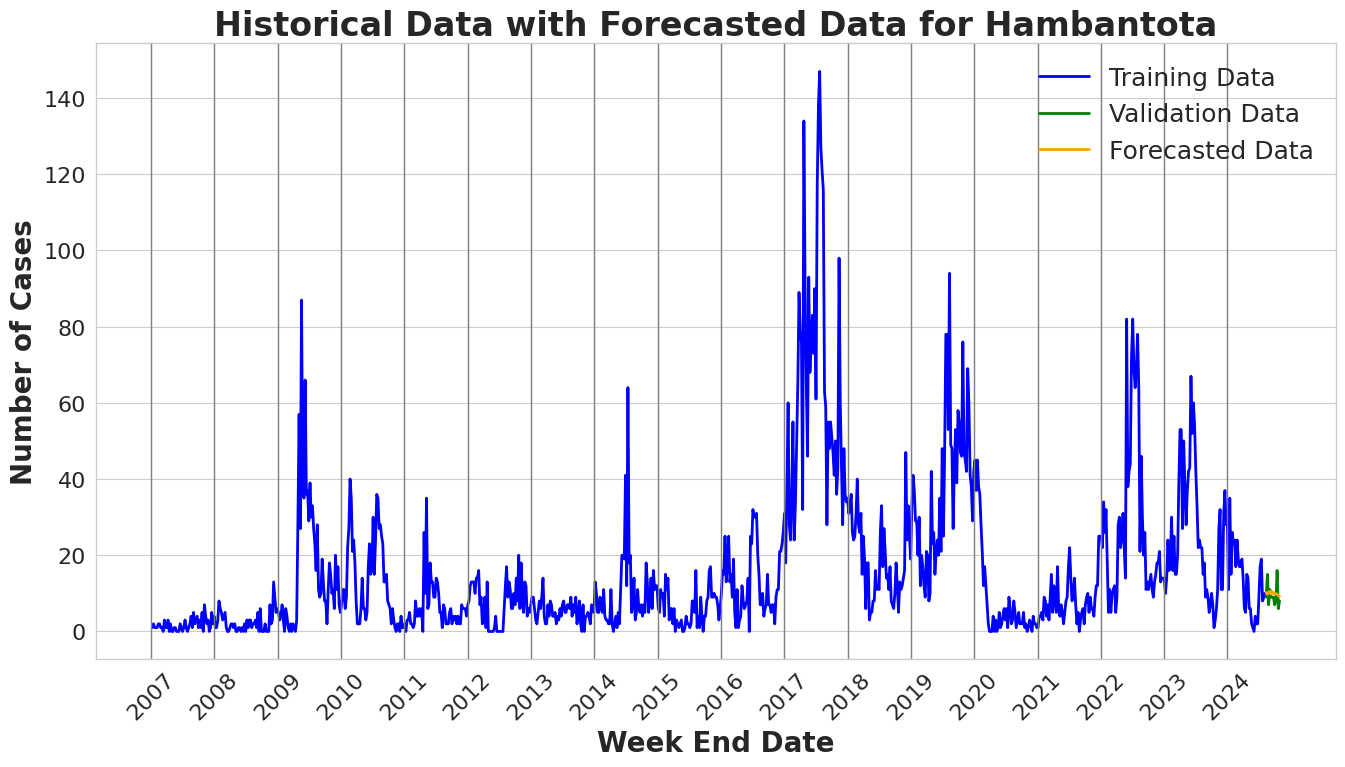

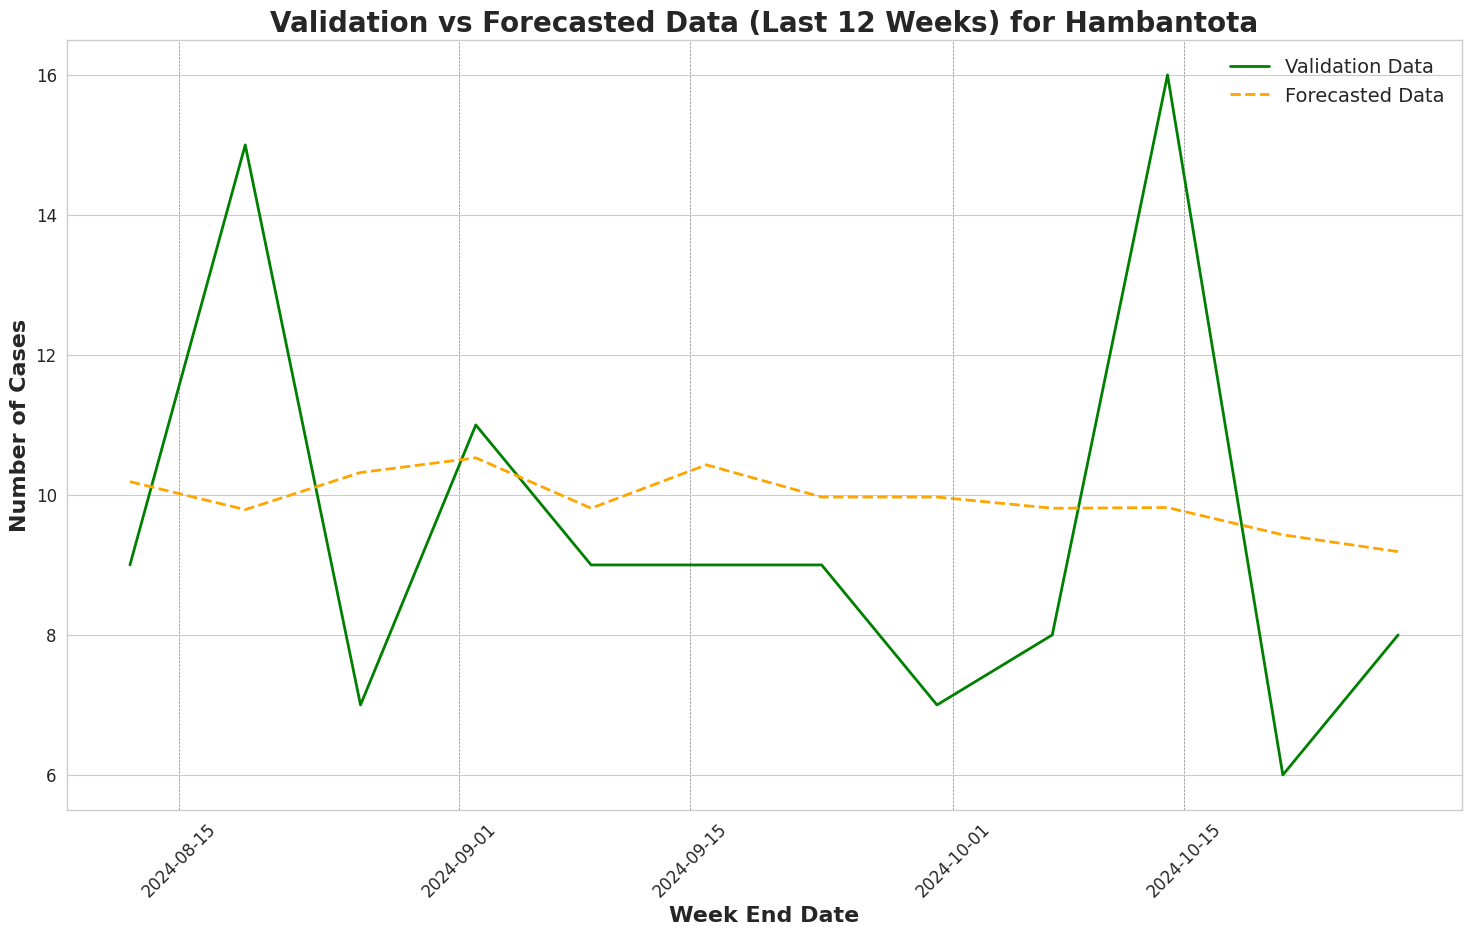

{'RMSE': 2.9849036835382146, 'MAE': 2.4150000000000005, 'SMAPE': 24.349979467378834, 'RMSLE': 0.2636747335763372}
Training length for Jaffna: 918
Validation length for Jaffna: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Jaffna: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Jaffna_ARIMA.pkl


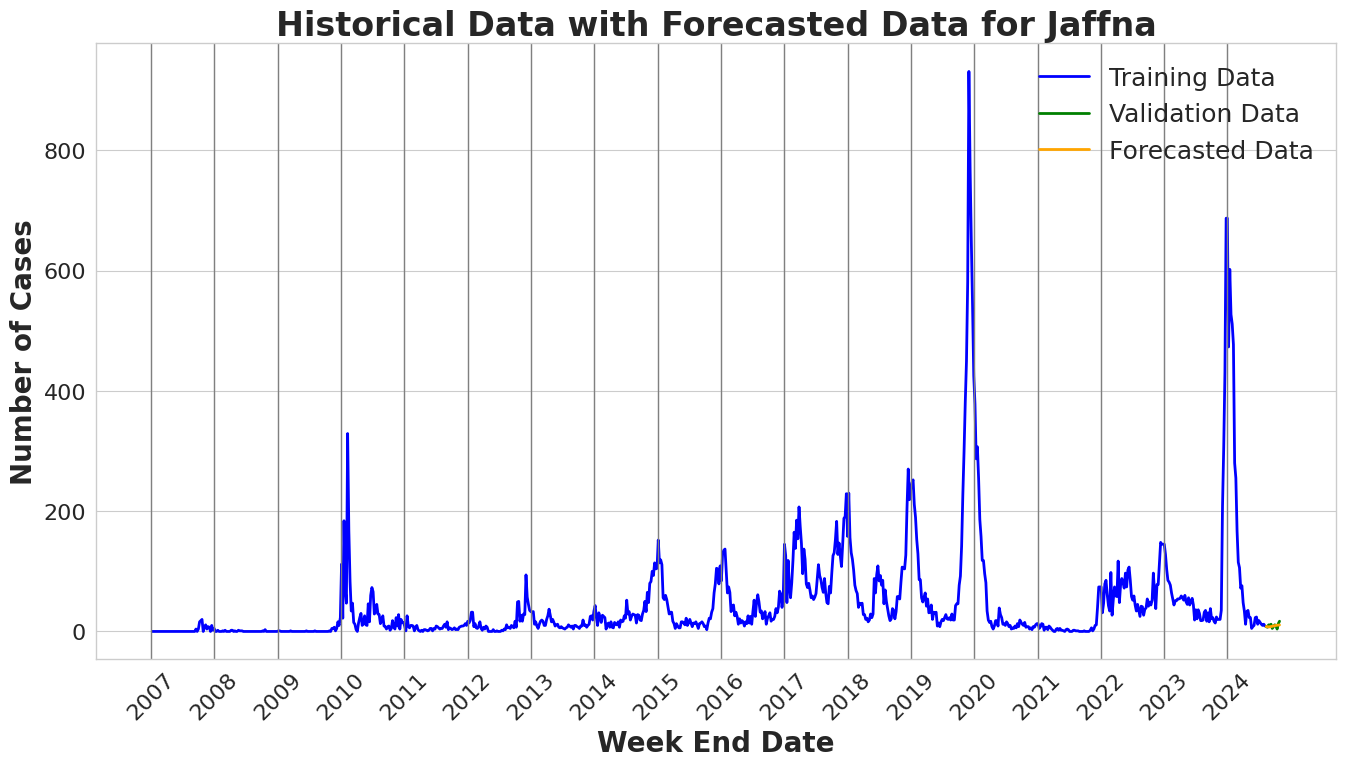

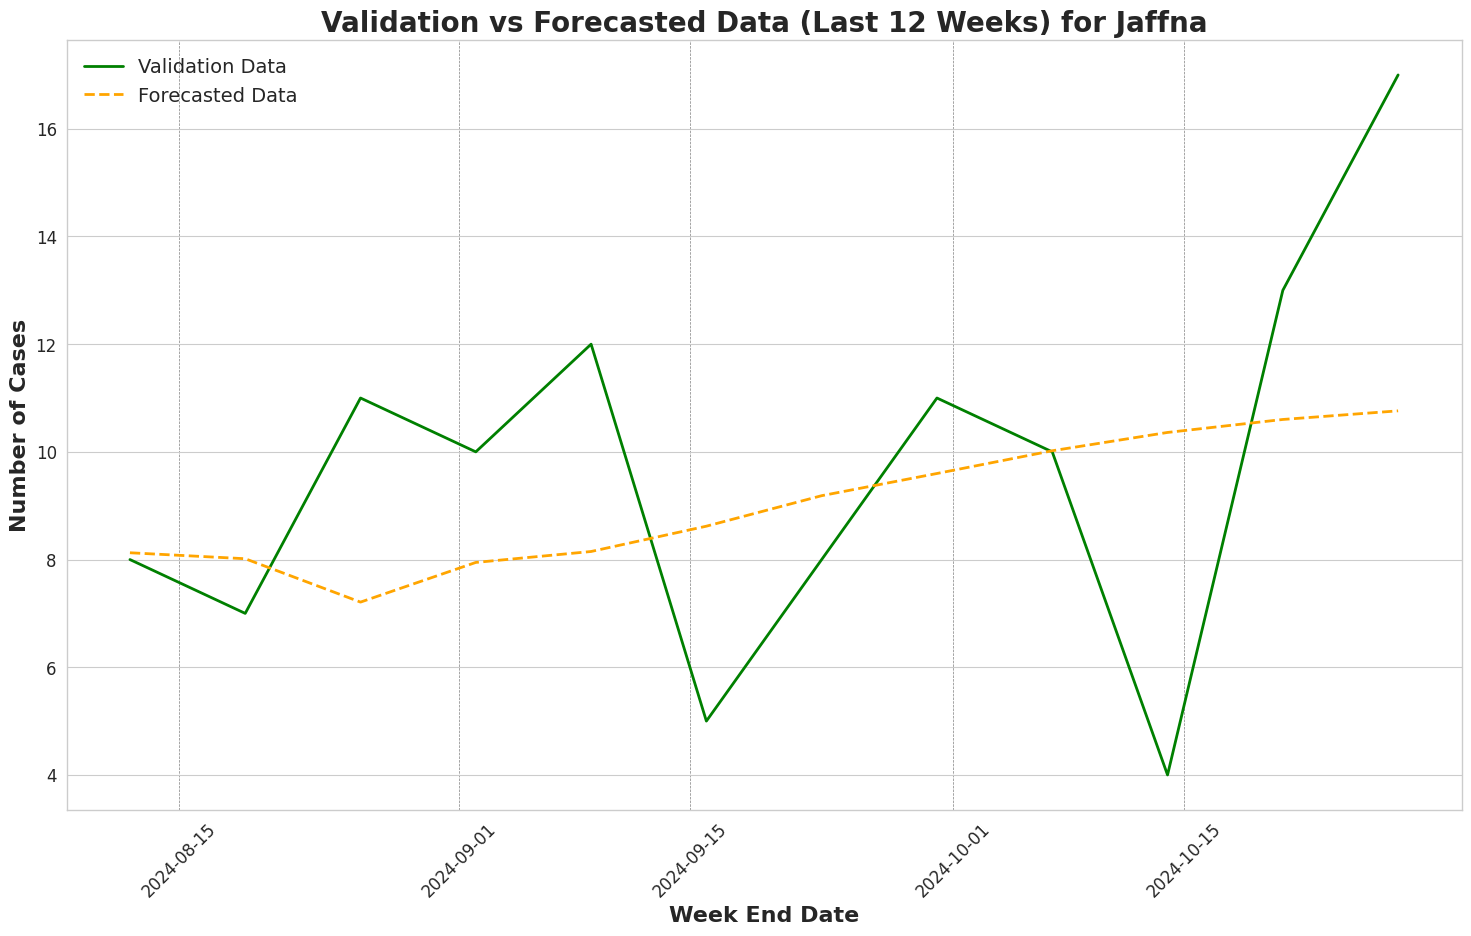

{'RMSE': 3.367158755940022, 'MAE': 2.671718410075927, 'SMAPE': 29.369868924965015, 'RMSLE': 0.3497781742148587}
Training length for Kalutara: 918
Validation length for Kalutara: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Kalutara: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Kalutara_RandomForest.pkl


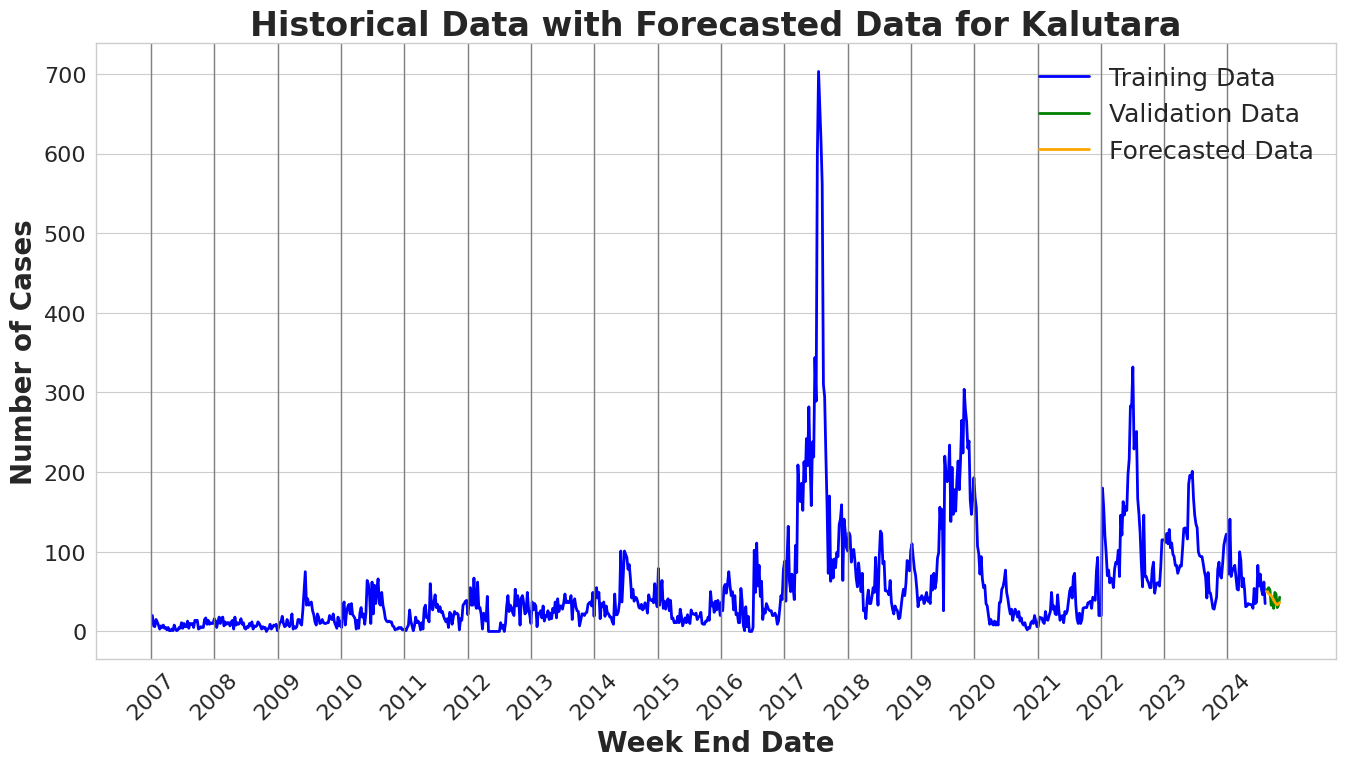

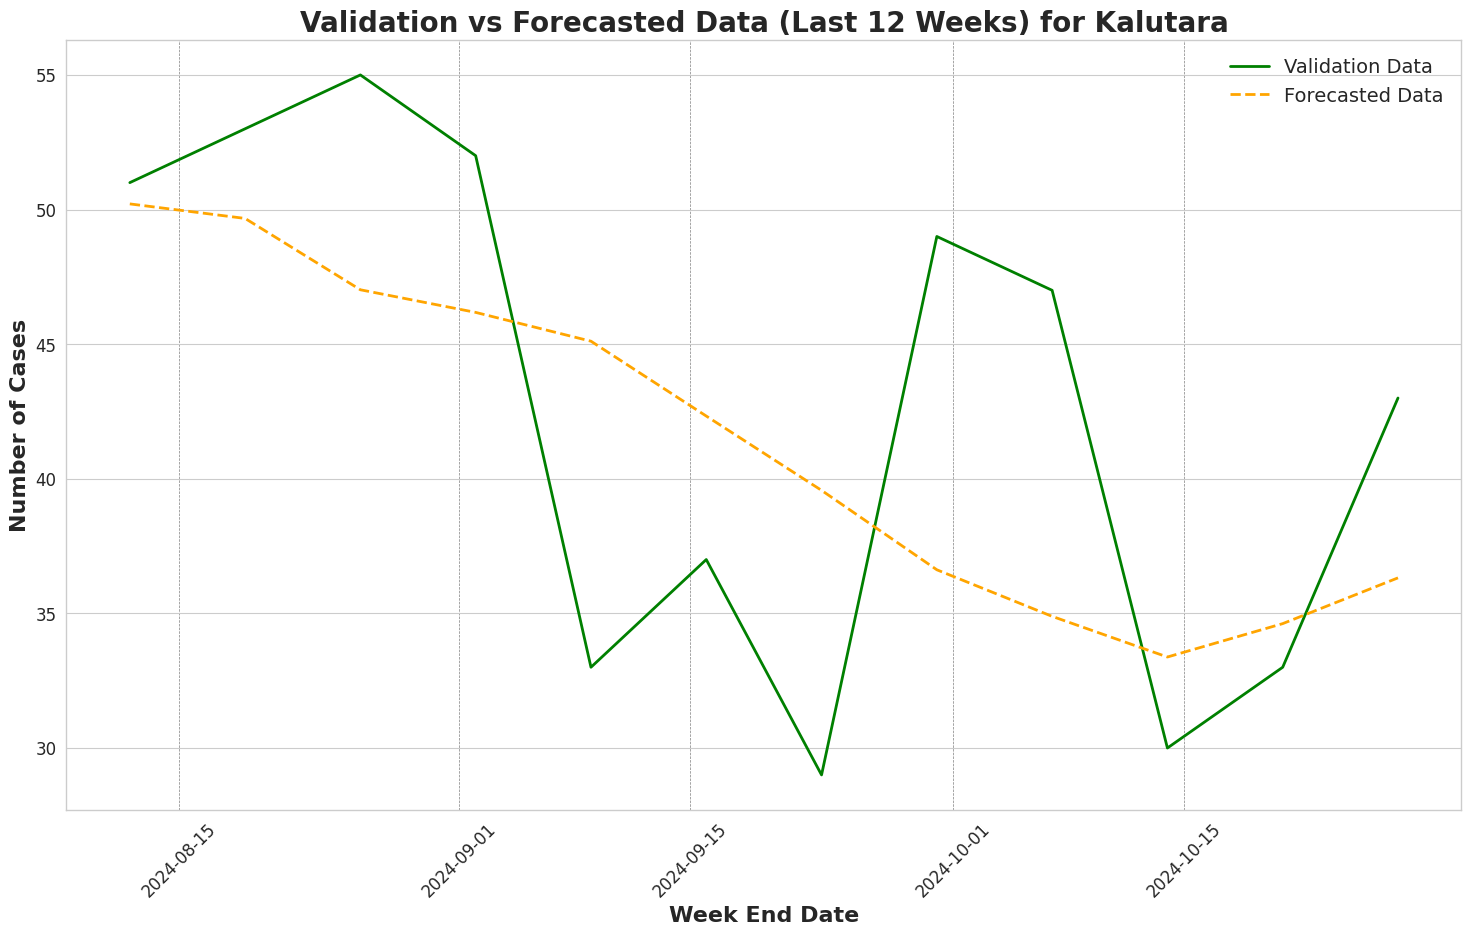

{'RMSE': 7.9301082380171, 'MAE': 6.841666666666666, 'SMAPE': 16.801482746366187, 'RMSLE': 0.19323099166768548}
Training length for Kandy: 918
Validation length for Kandy: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Kandy: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Kandy_ARIMA.pkl


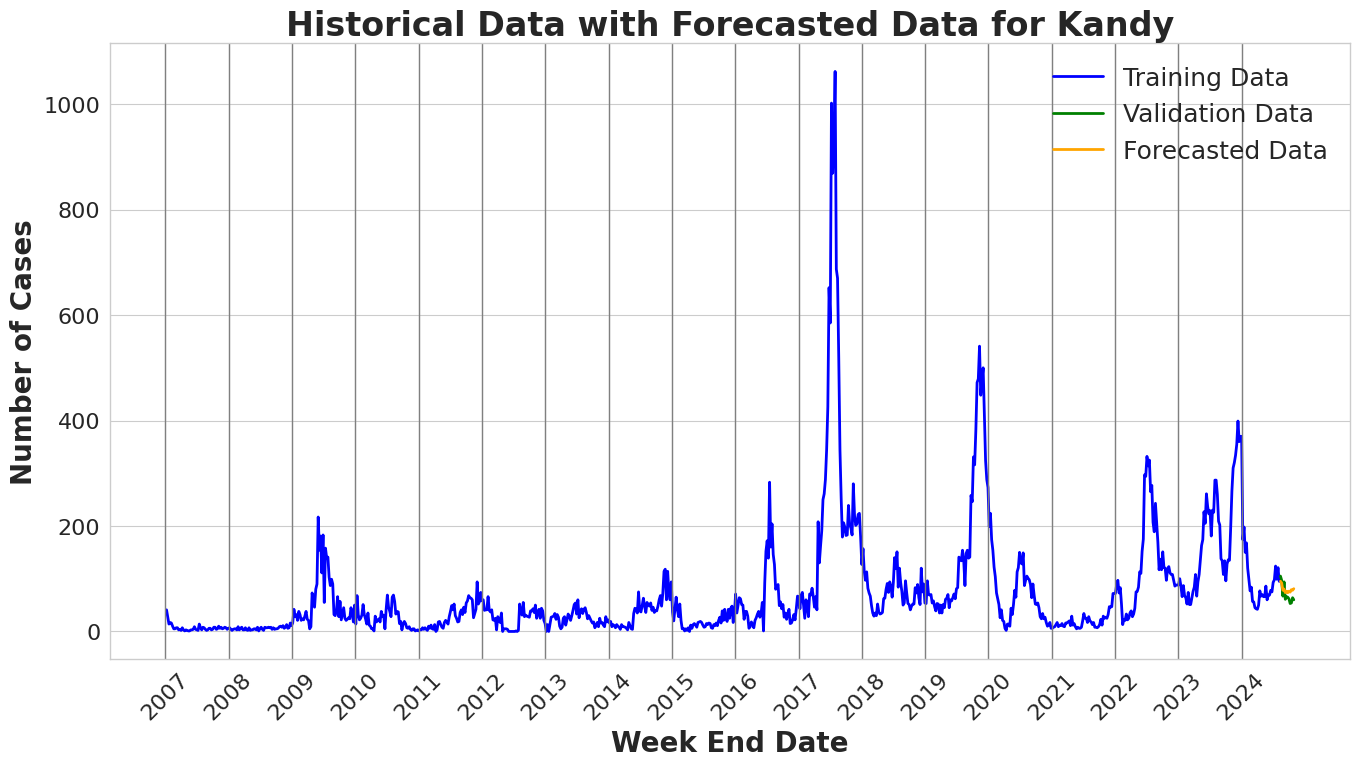

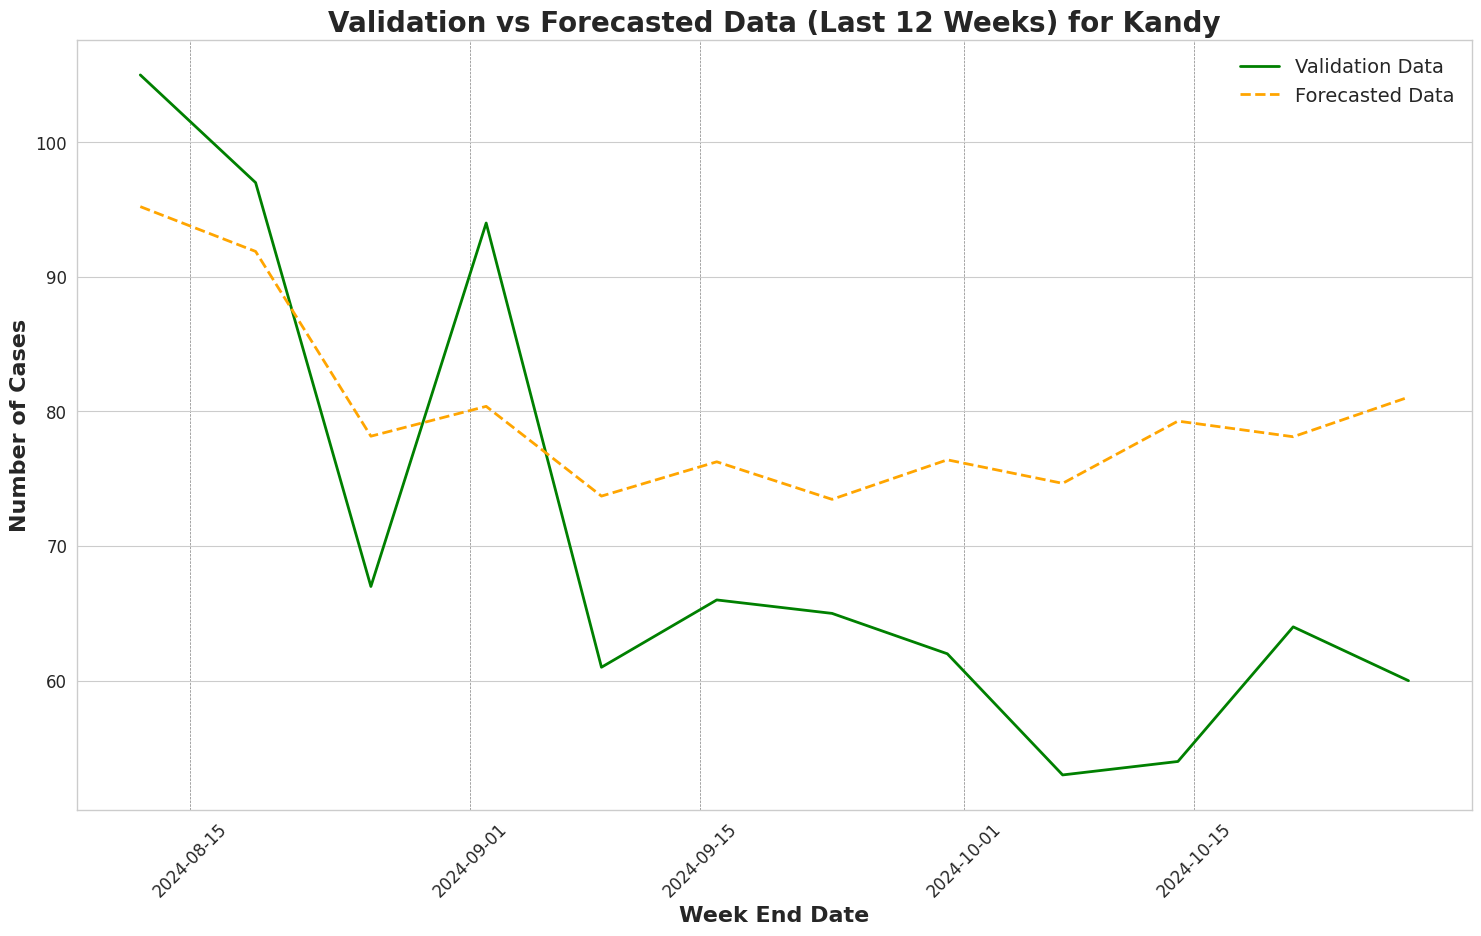

{'RMSE': 15.08271775349699, 'MAE': 13.972007535997475, 'SMAPE': 19.51305417899386, 'RMSLE': 0.2150314935849418}
Training length for Kegalle: 918
Validation length for Kegalle: 12
Model saved for Kegalle: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Kegalle_LinearRegressionModel.pkl


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


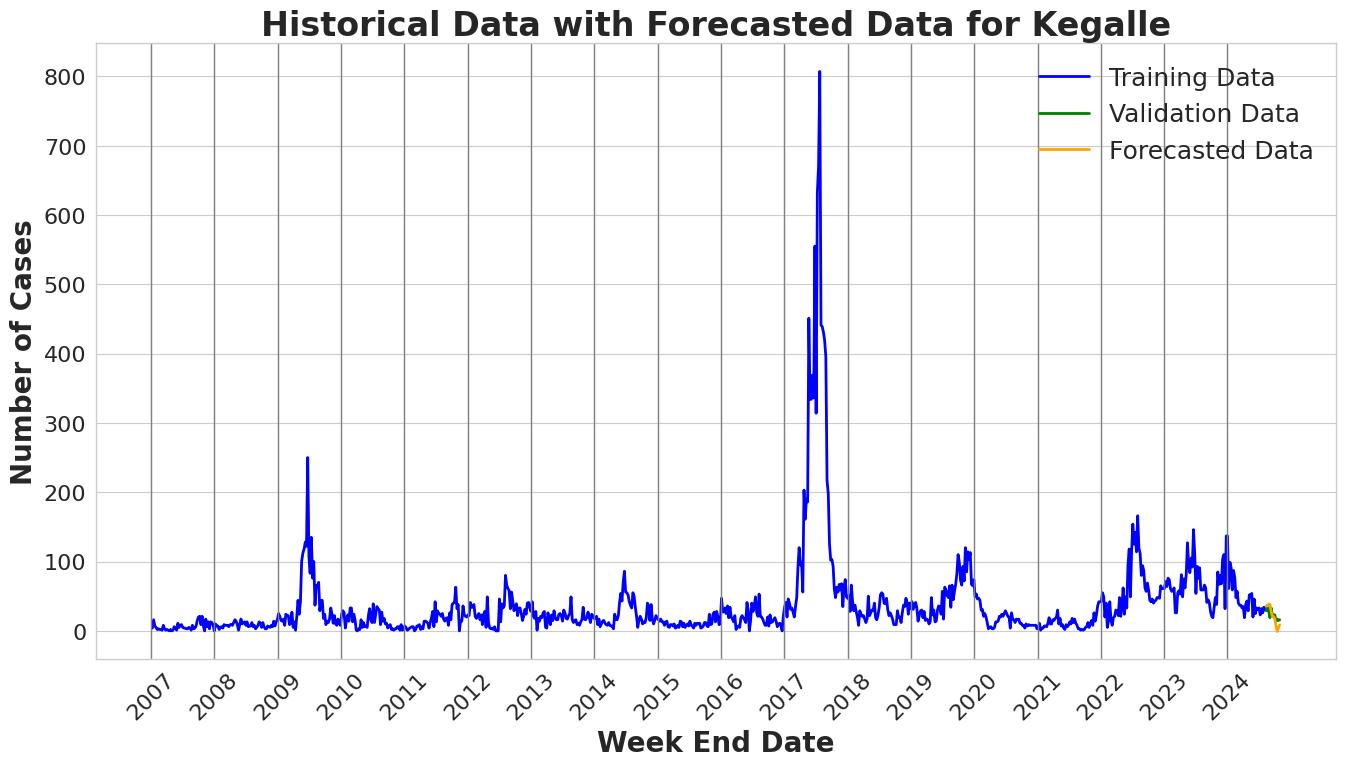

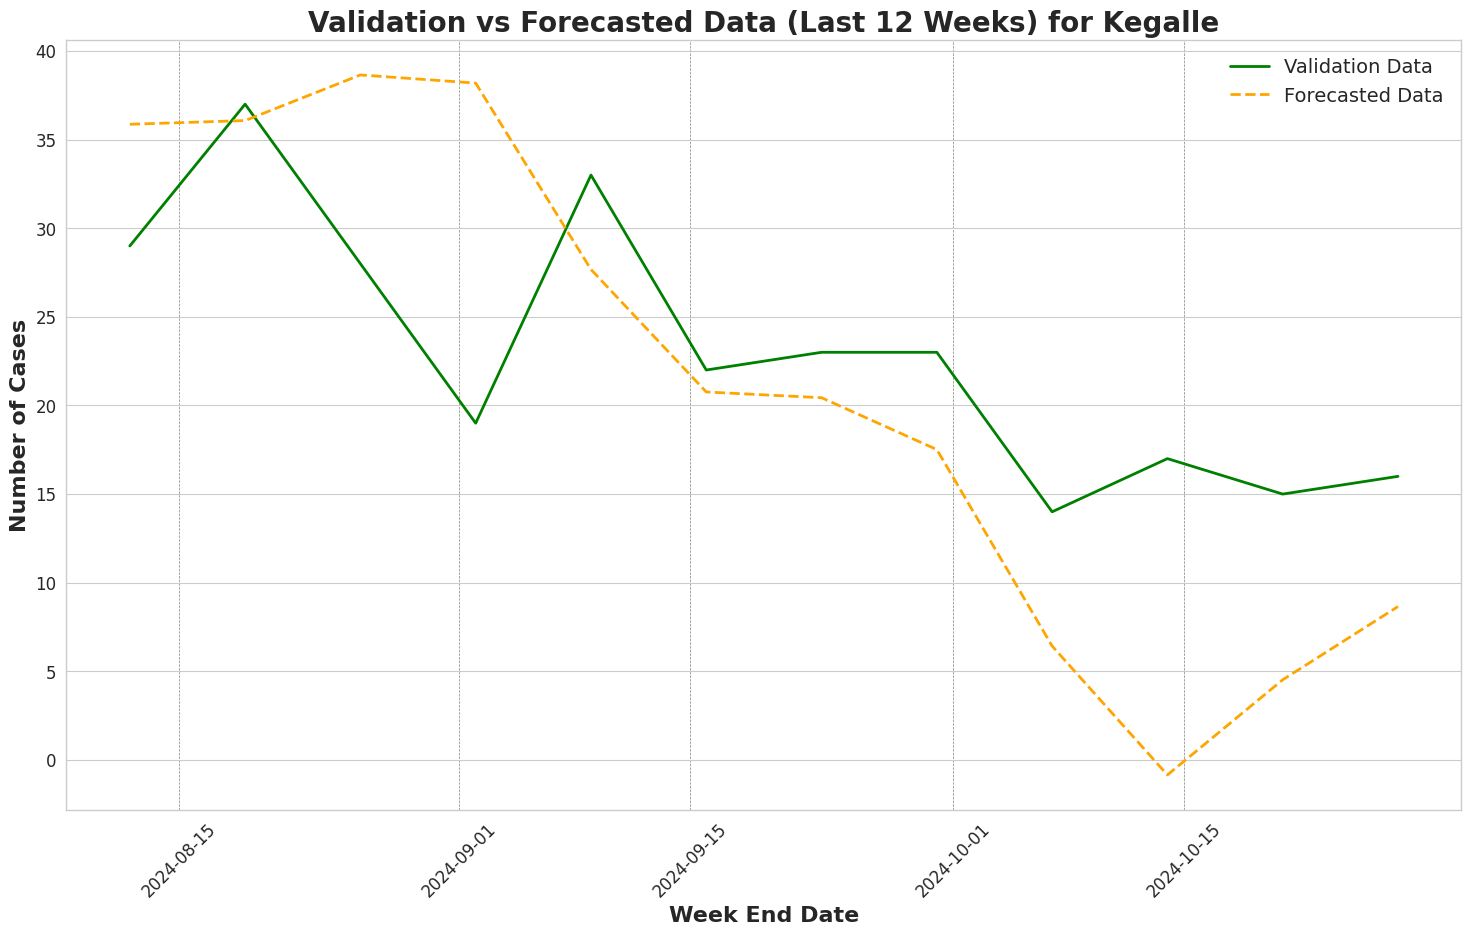

{'RMSE': 9.729152730796926, 'MAE': 7.957743728404371, 'SMAPE': 52.17735812778591, 'RMSLE': 1.454941833545446}
Training length for Kilinochchi: 918
Validation length for Kilinochchi: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Kilinochchi: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Kilinochchi_ExponentialSmoothing.pkl


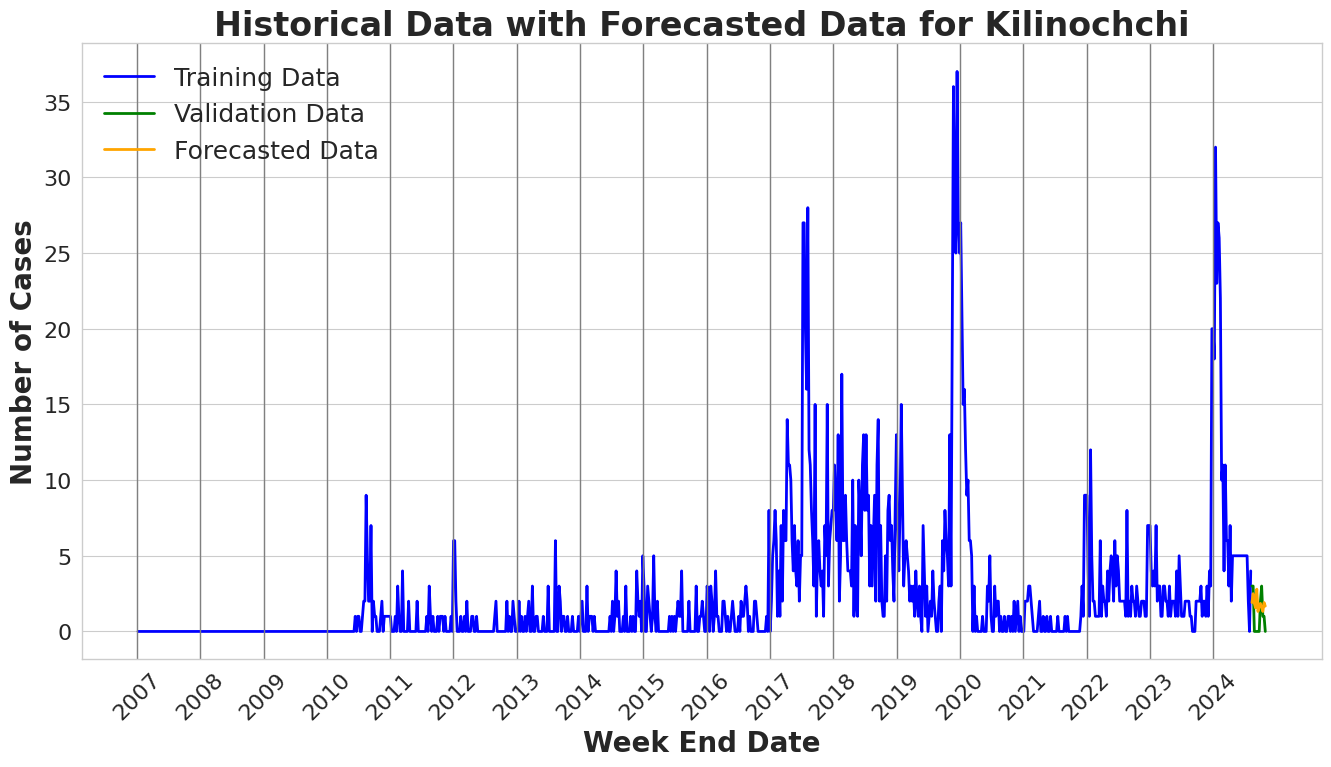

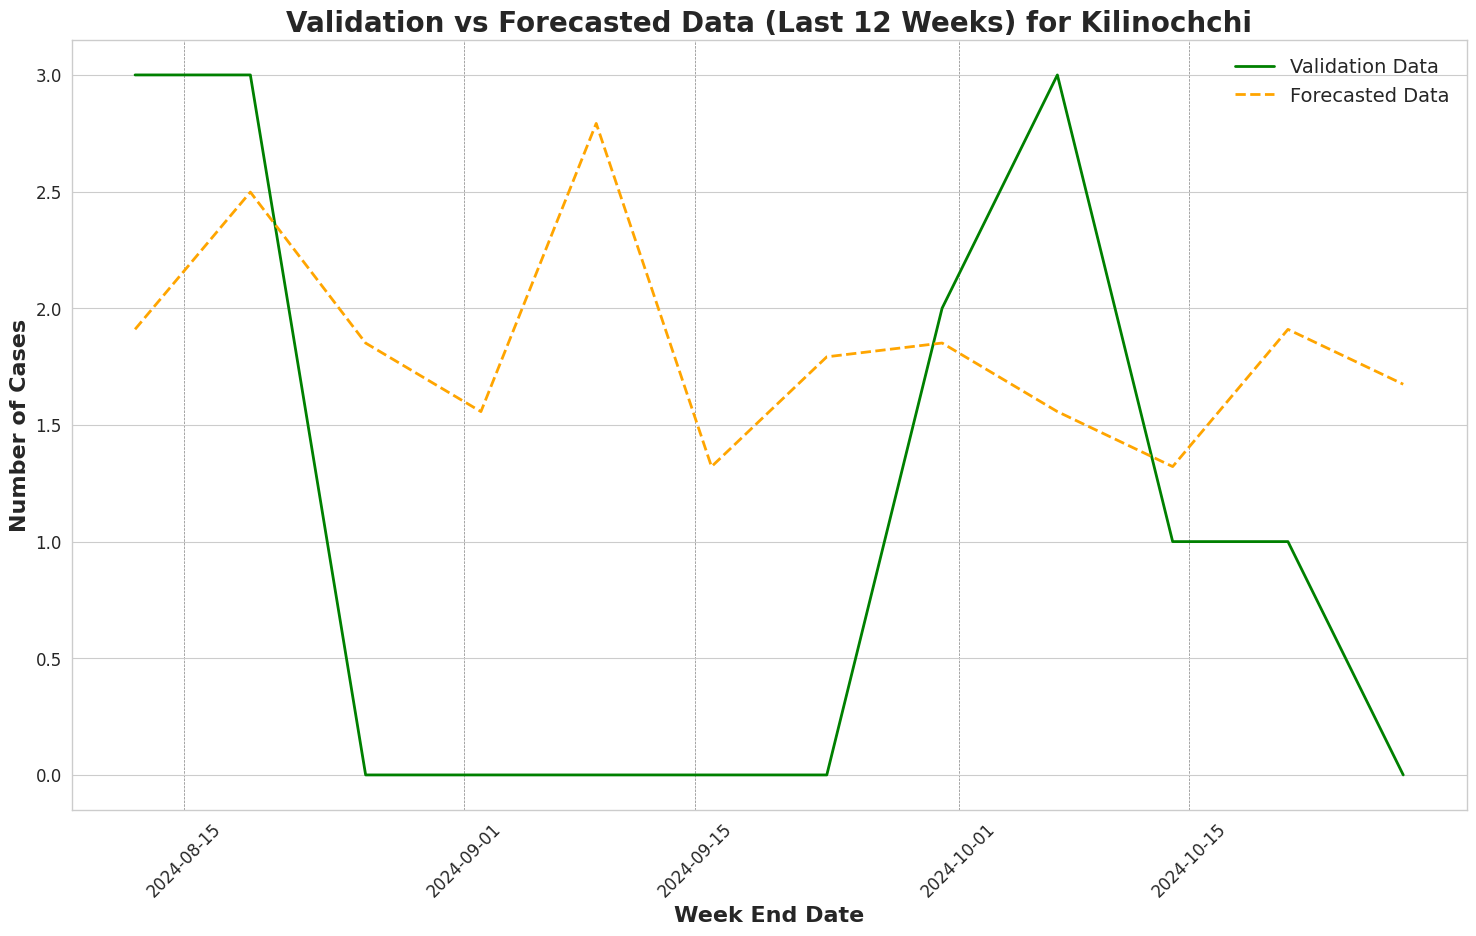

{'RMSE': 1.468640517628706, 'MAE': 1.2835830307452225, 'SMAPE': 118.66227437905236, 'RMSLE': 0.7622139092597502}
Training length for Kurunegala: 918
Validation length for Kurunegala: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Kurunegala: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Kurunegala_CatBoostModel.pkl


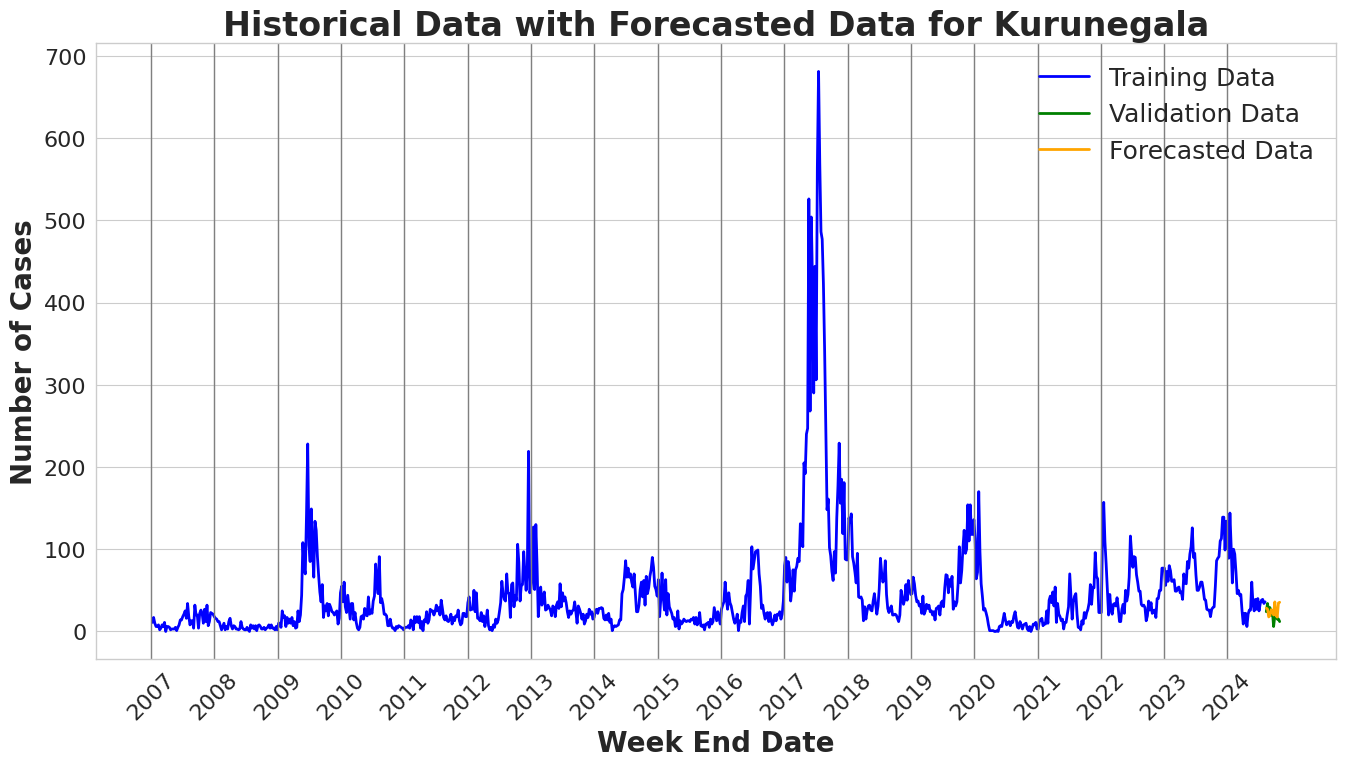

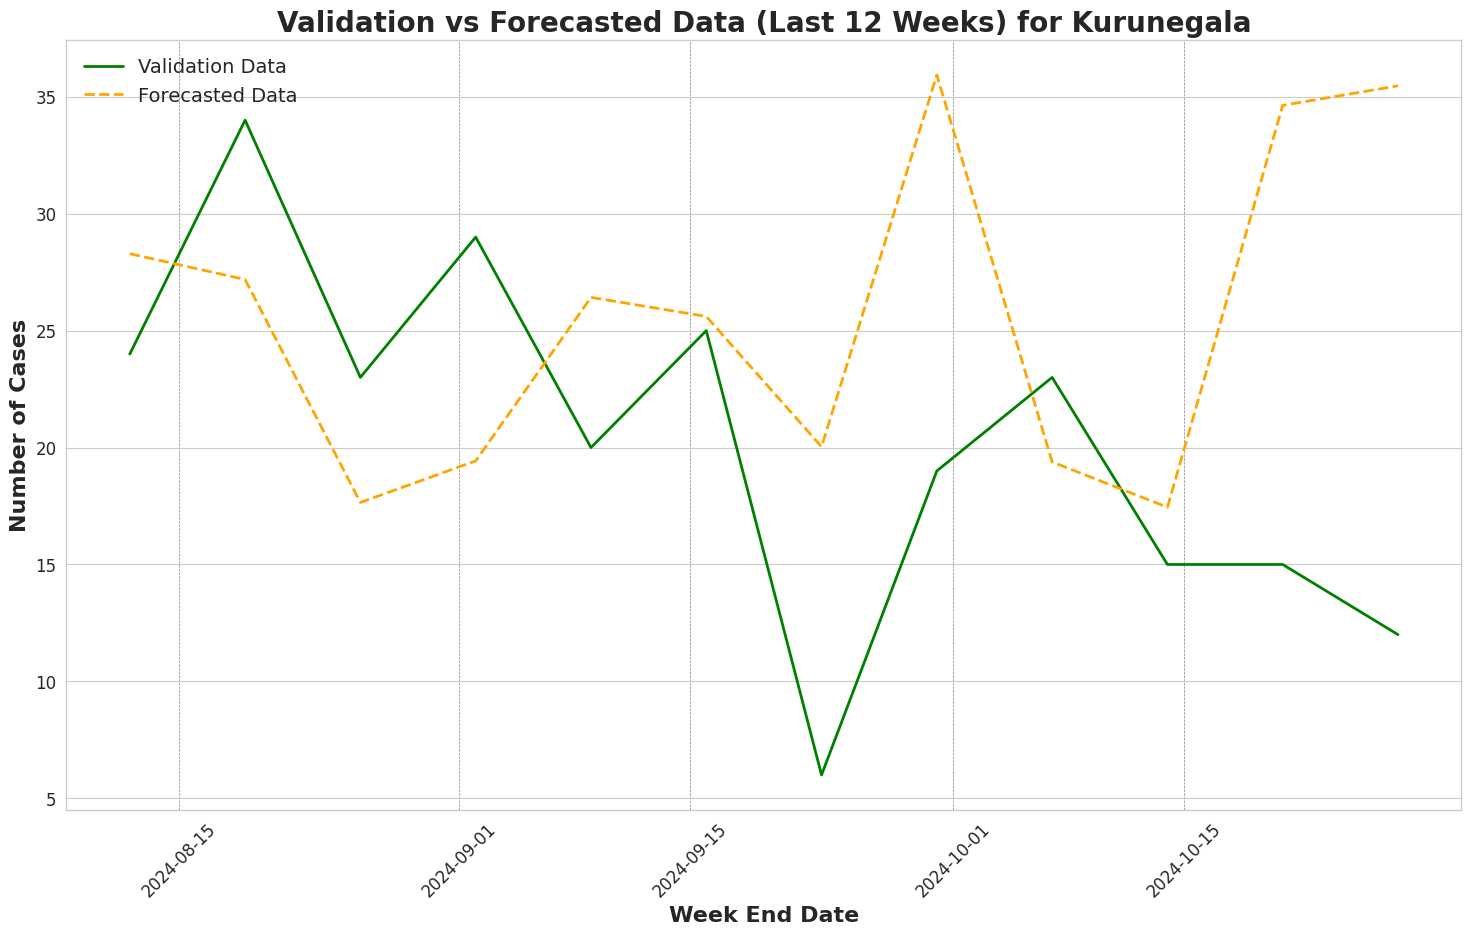

{'RMSE': 11.781482885474901, 'MAE': 9.43188034423825, 'SMAPE': 42.84853673541064, 'RMSLE': 0.5548012604580107}
Training length for Mannar: 918
Validation length for Mannar: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Mannar: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Mannar_AutoARIMA.pkl


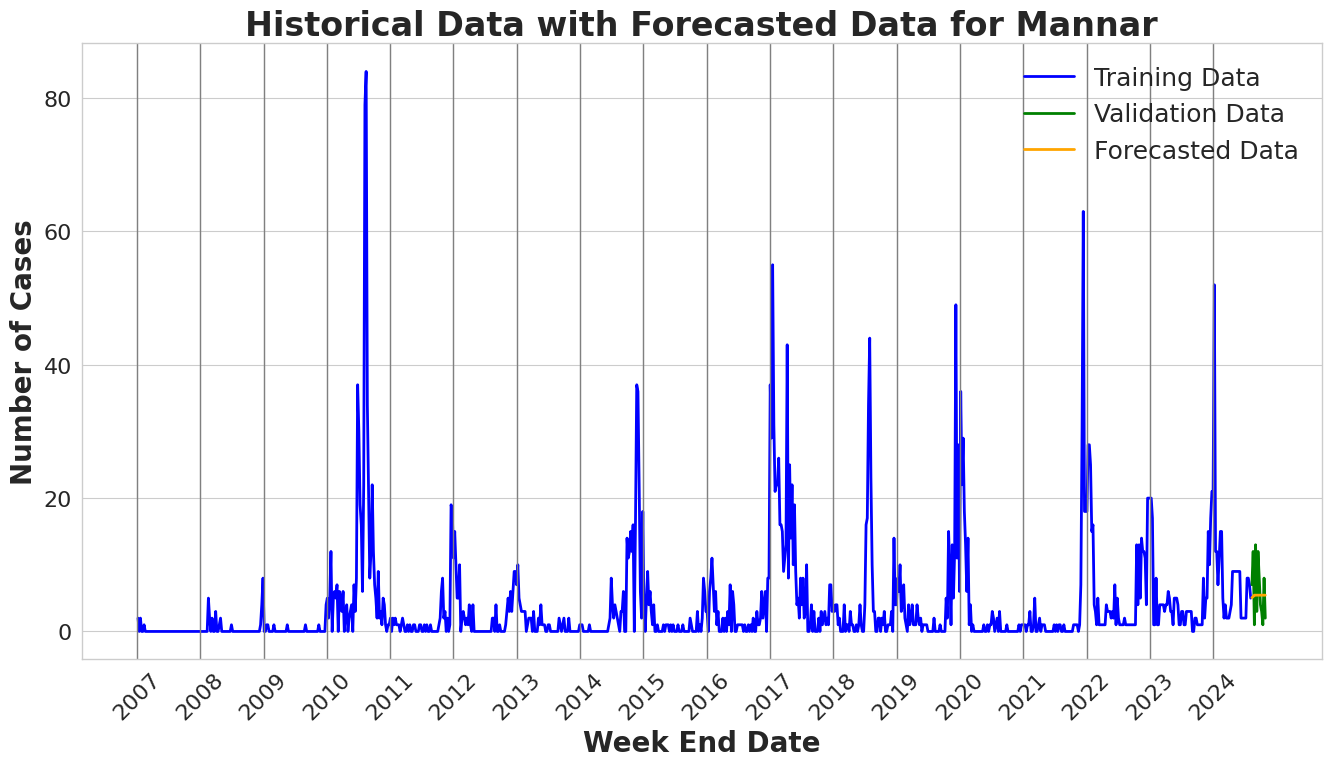

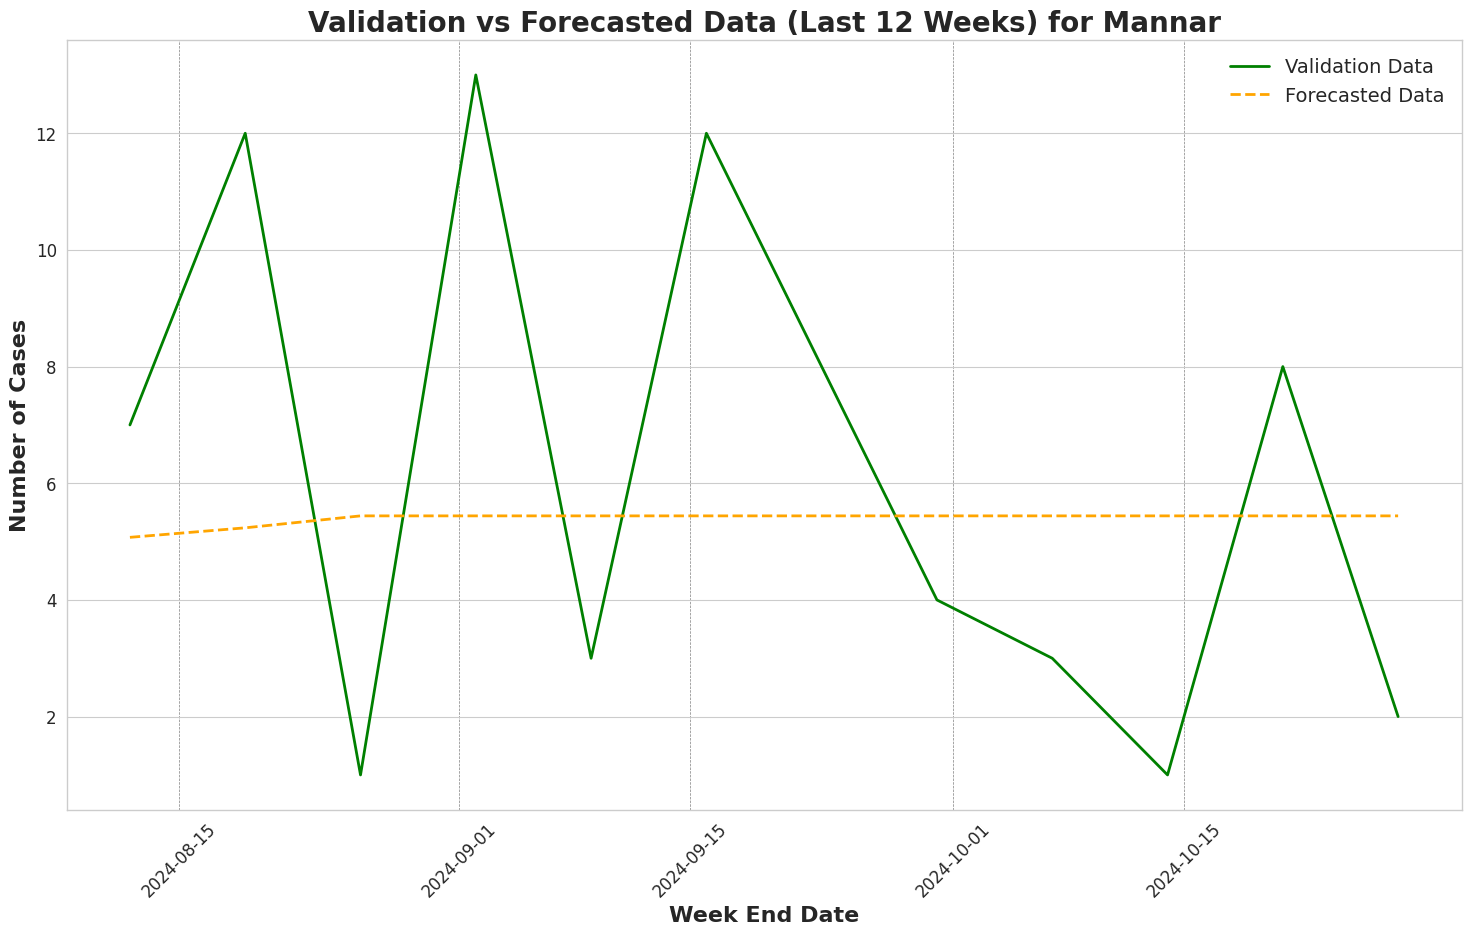

{'RMSE': 4.358854735493346, 'MAE': 3.881062369131108, 'SMAPE': 71.51966484224259, 'RMSLE': 0.6935902723119309}
Training length for Matale: 918
Validation length for Matale: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Matale: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Matale_RandomForest.pkl


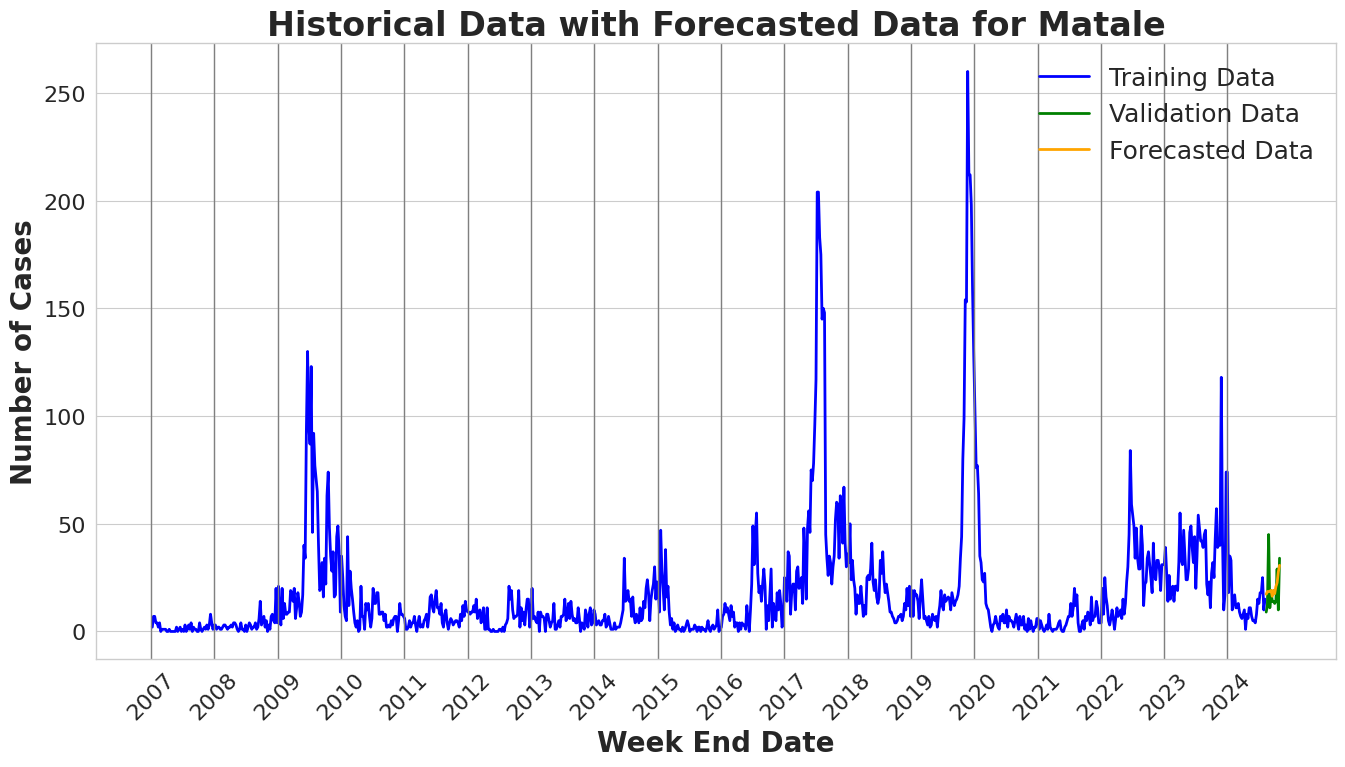

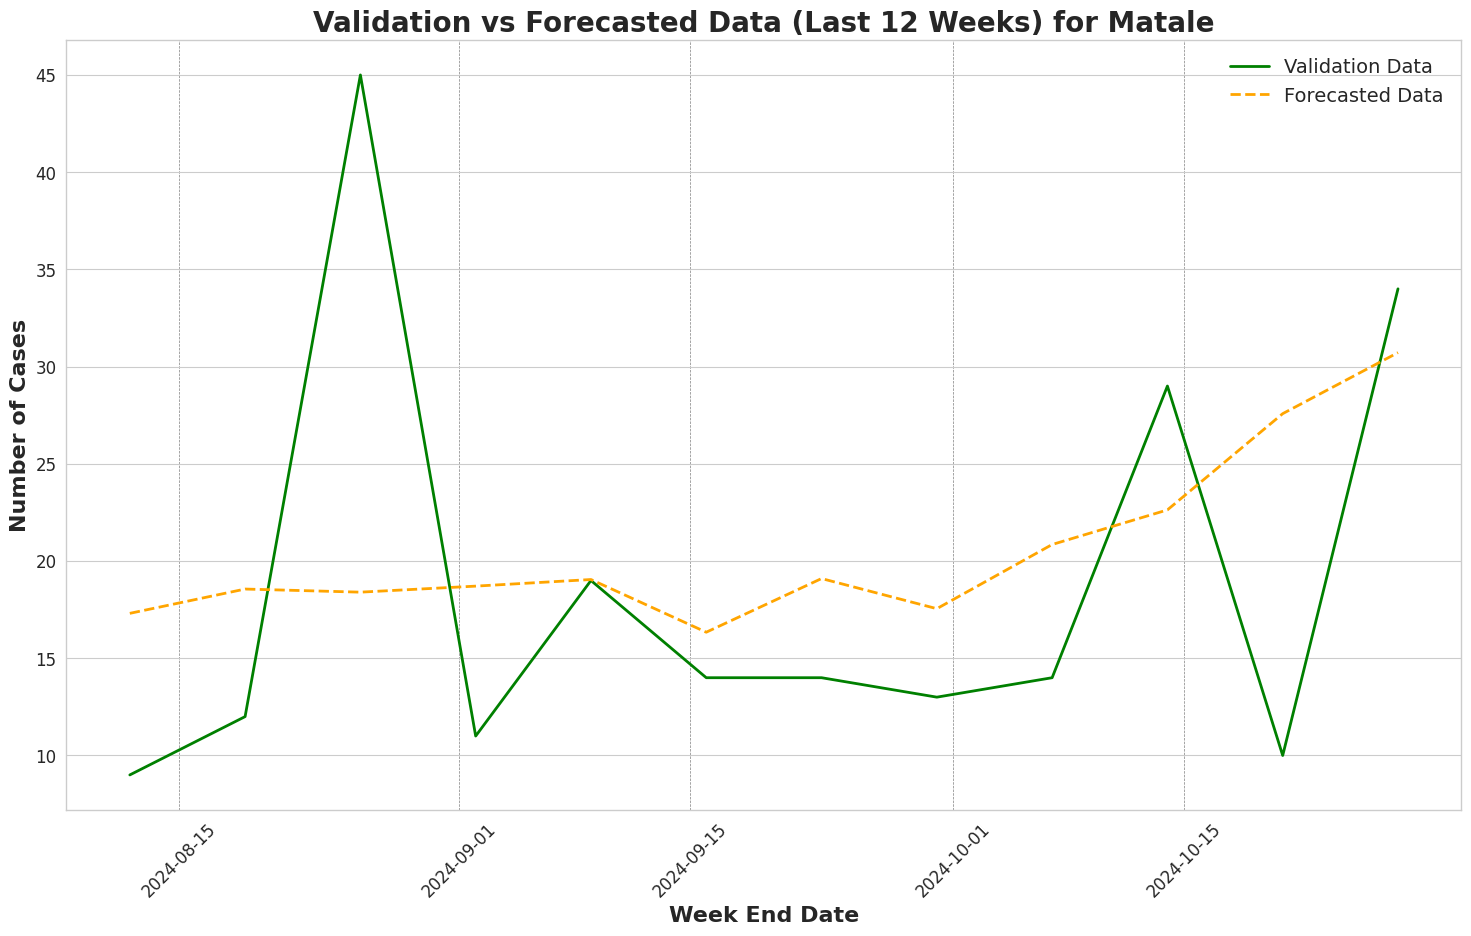

{'RMSE': 10.561717821137494, 'MAE': 7.941666666666666, 'SMAPE': 40.49078714651381, 'RMSLE': 0.48563323042600737}
Training length for Matara: 918
Validation length for Matara: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Matara: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Matara_AutoARIMA.pkl


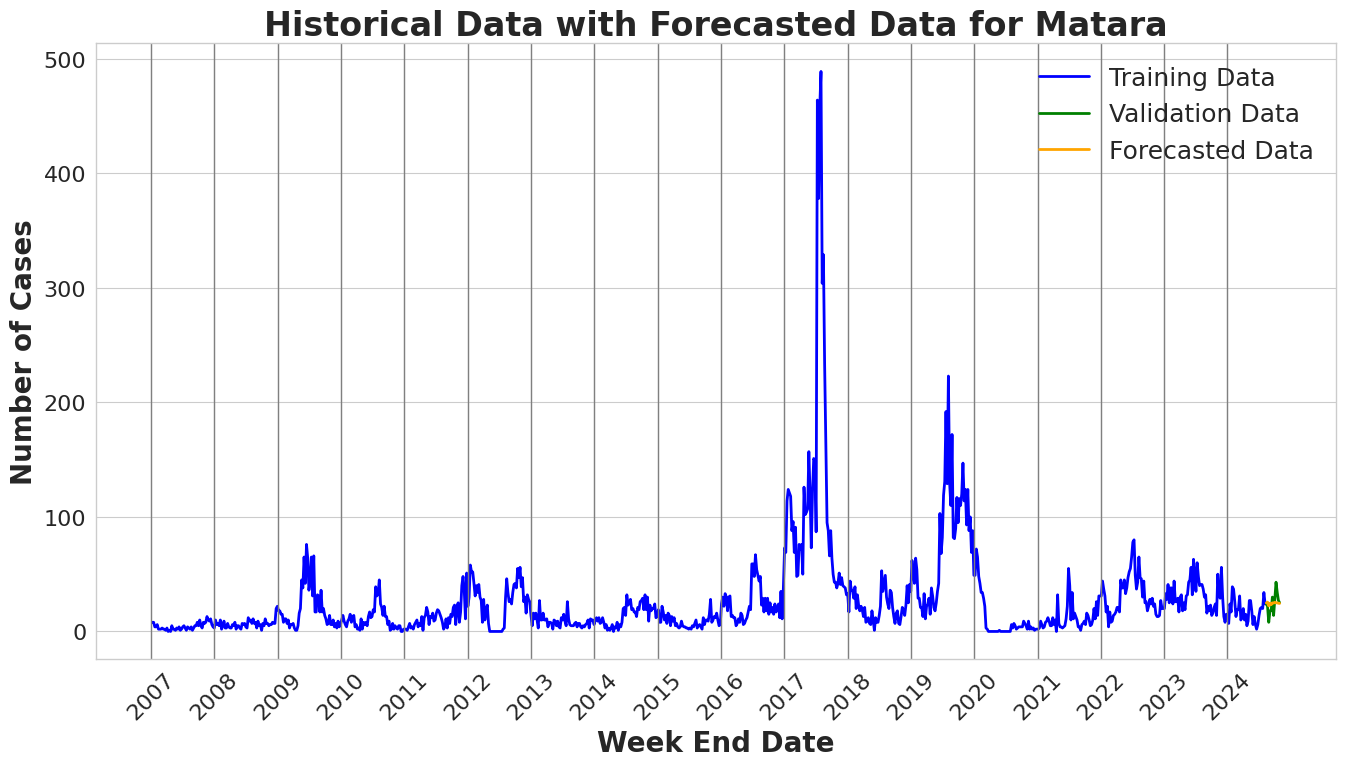

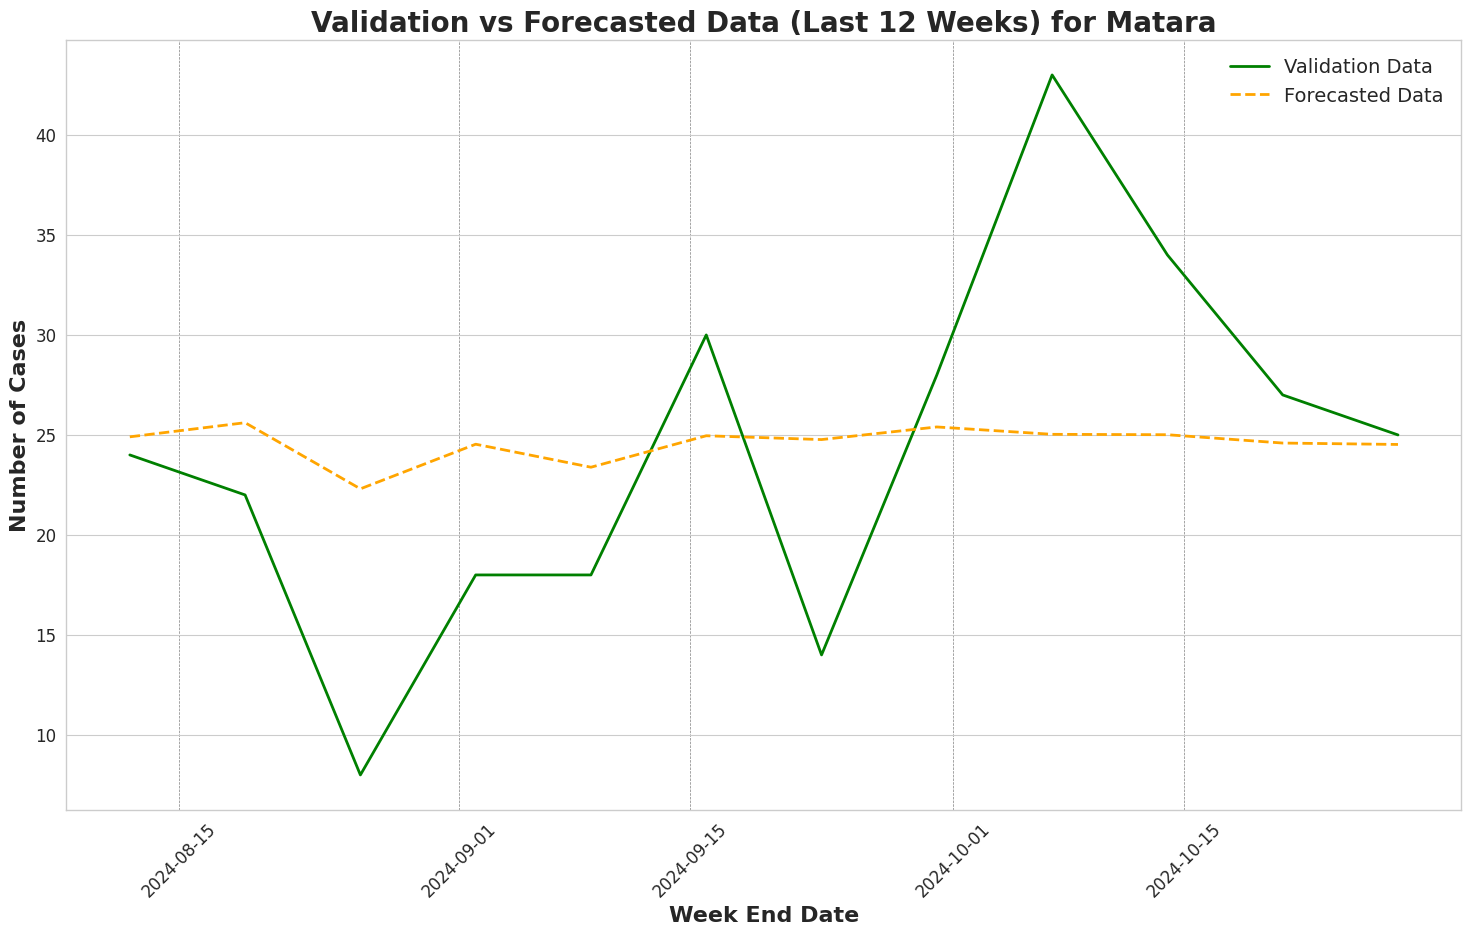

<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr98etxo/3wk_qy4f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr98etxo/xn7tgd3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92074', 'data', 'file=/tmp/tmpzr98etxo/3wk_qy4f.json', 'init=/tmp/t

{'RMSE': 8.40664962304472, 'MAE': 6.582804499701396, 'SMAPE': 29.018048047970364, 'RMSLE': 0.38542336171902397}
Training length for Monaragala: 918
Validation length for Monaragala: 12


12:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model saved for Monaragala: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Monaragala_Prophet.pkl


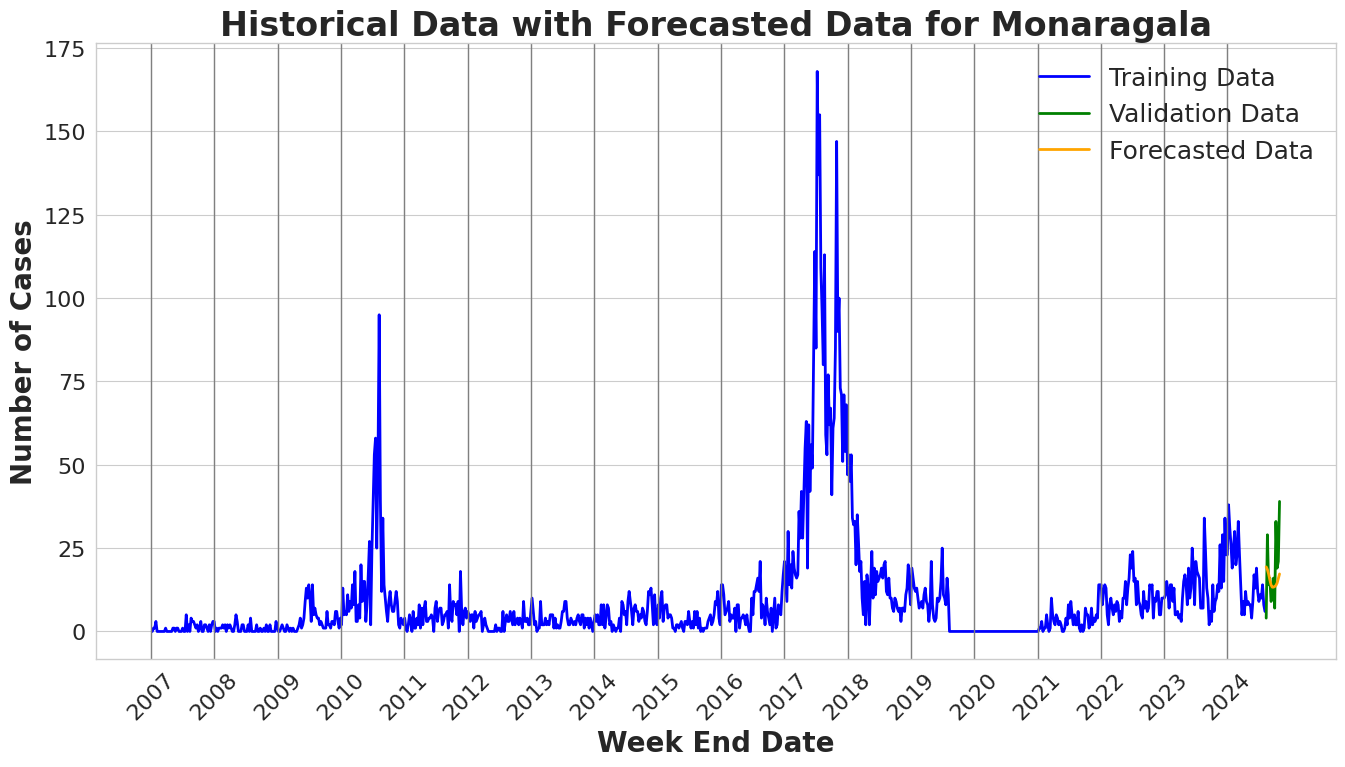

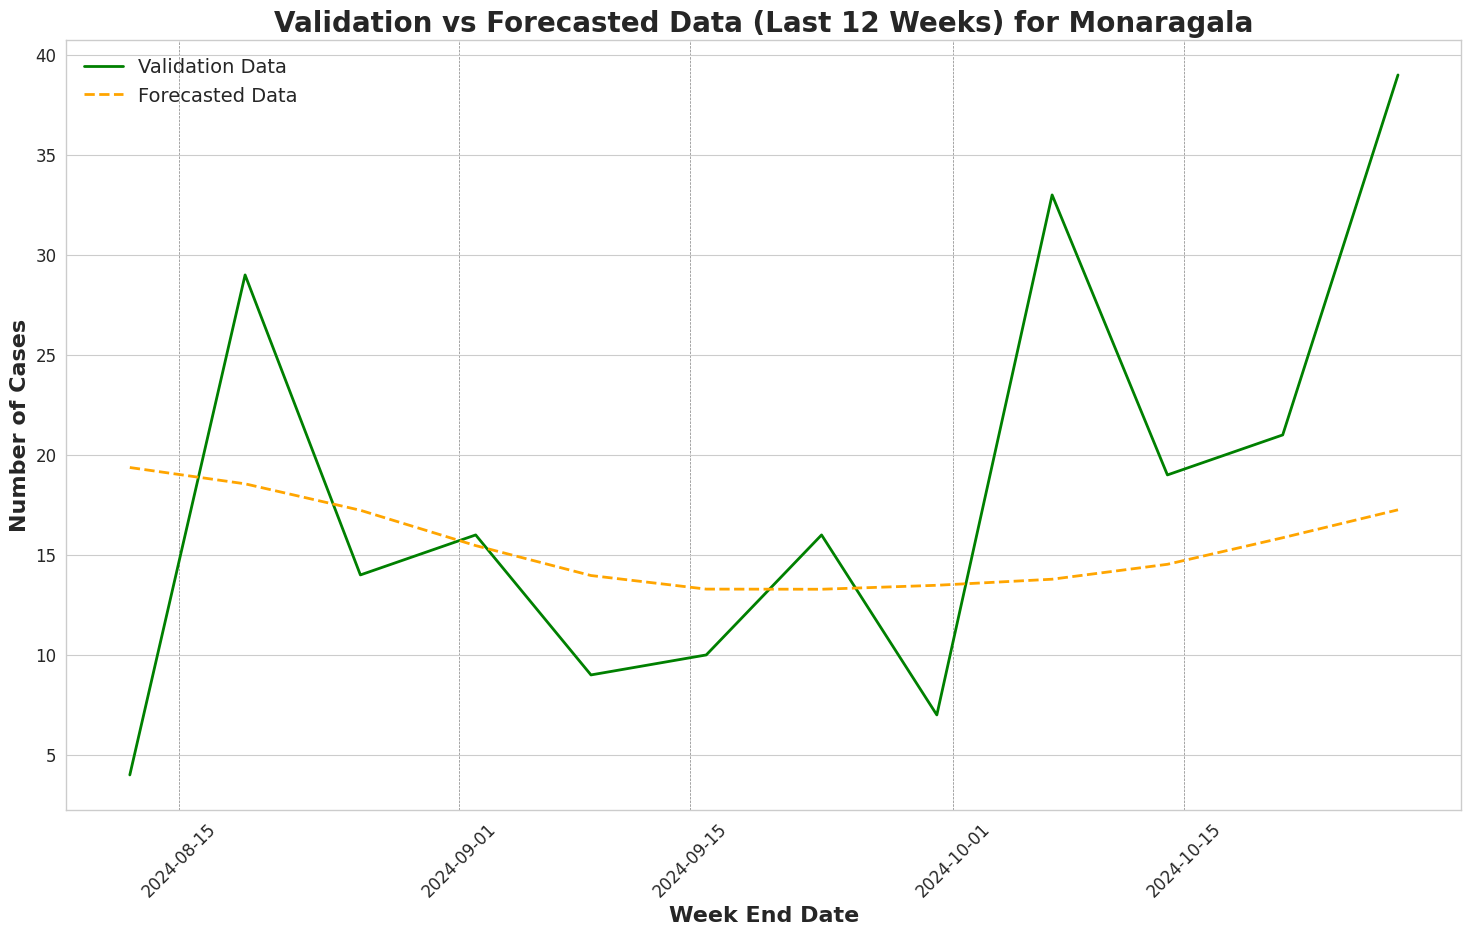

{'RMSE': 10.525430865927817, 'MAE': 8.134064755937924, 'SMAPE': 47.24366602558851, 'RMSLE': 0.5953034314331734}
Training length for Mullaitivu: 918
Validation length for Mullaitivu: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Mullaitivu: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Mullaitivu_AutoARIMA.pkl


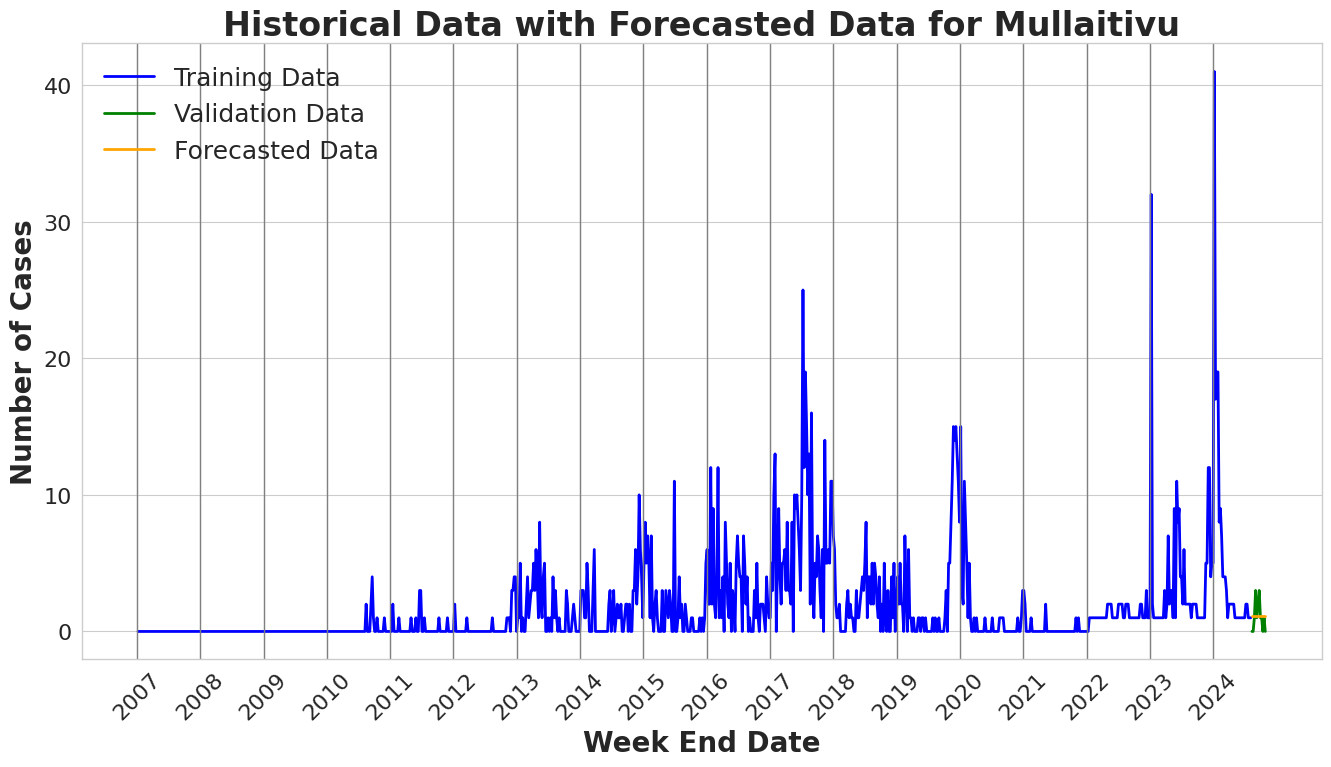

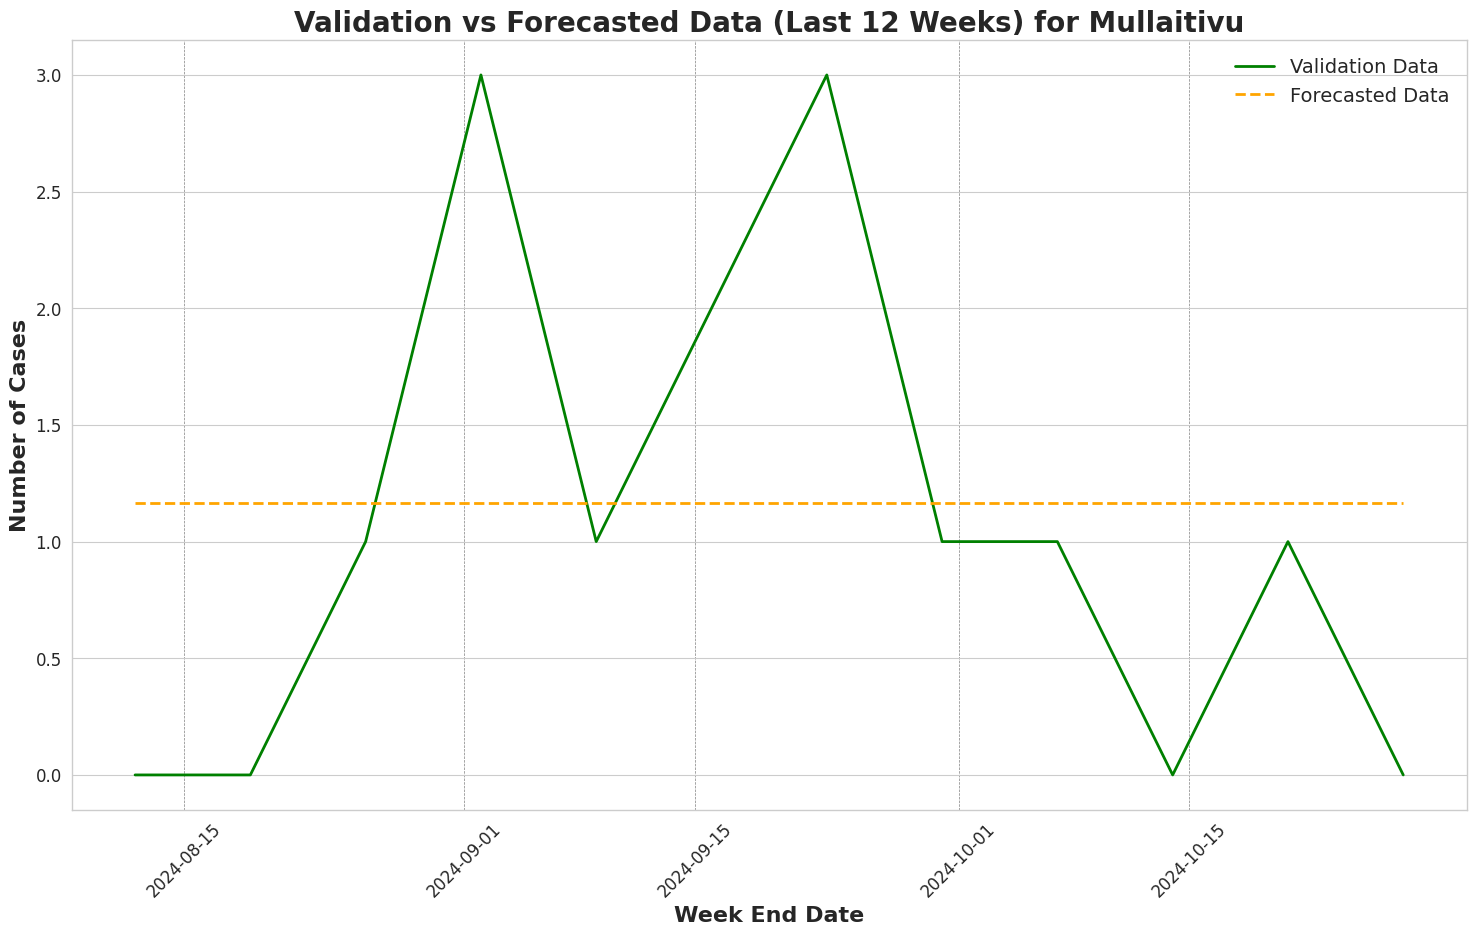

<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr98etxo/4w_url5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr98etxo/togw6reu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57174', 'data', 'file=/tmp/tmpzr98etxo/4w_url5g.json', 'init=/tmp/t

{'RMSE': 1.0407566962315449, 'MAE': 0.832854079373437, 'SMAPE': 92.11292856099601, 'RMSLE': 0.5227573395166253}
Training length for NuwaraEliya: 918
Validation length for NuwaraEliya: 12


12:42:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model saved for NuwaraEliya: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/NuwaraEliya_Prophet.pkl


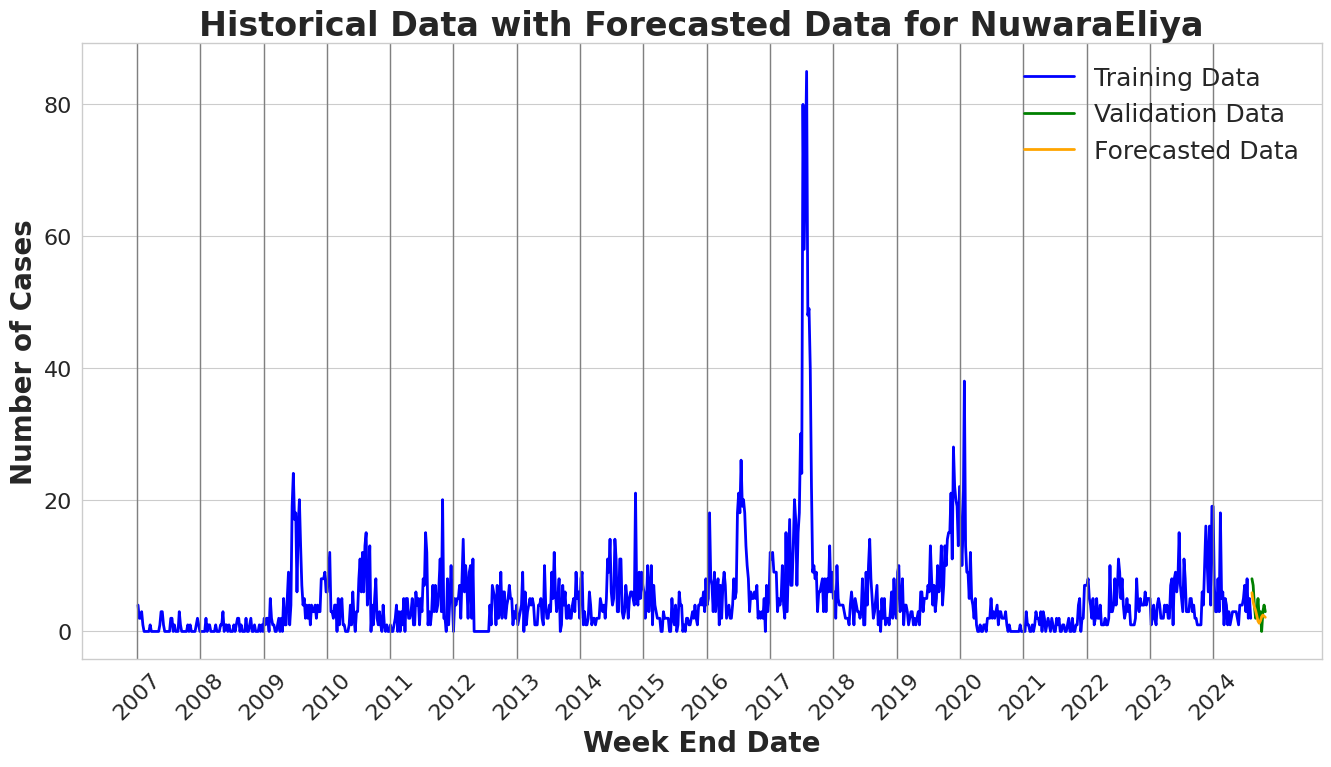

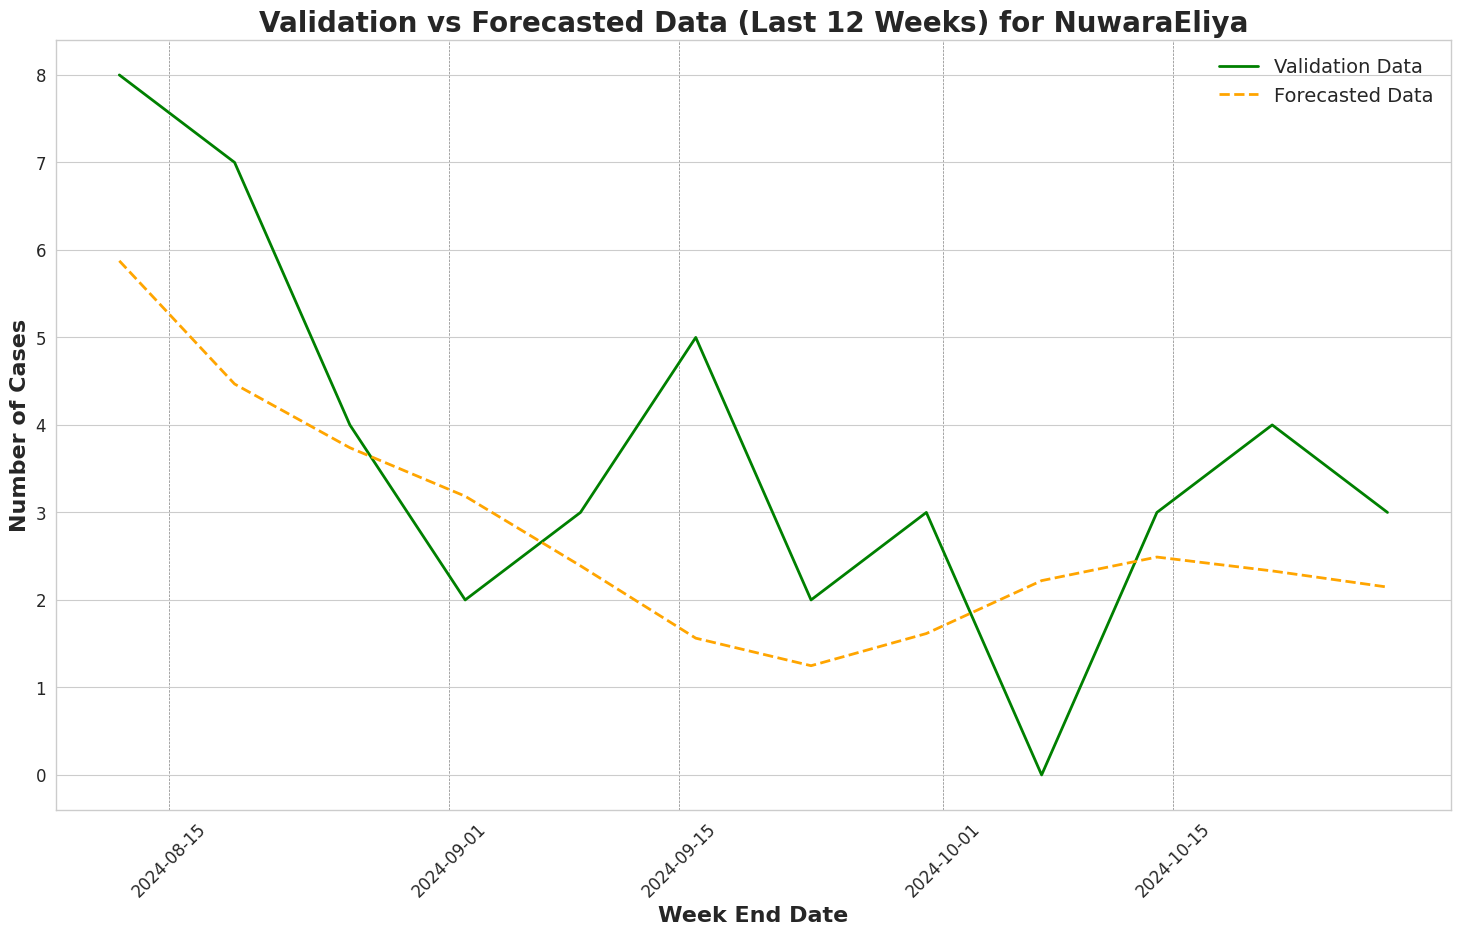

{'RMSE': 1.7264544091350948, 'MAE': 1.4614933484767032, 'SMAPE': 55.442094937326566, 'RMSLE': 0.4961862300683488}
Training length for Polonnaruwa: 918
Validation length for Polonnaruwa: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Polonnaruwa: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Polonnaruwa_AutoARIMA.pkl


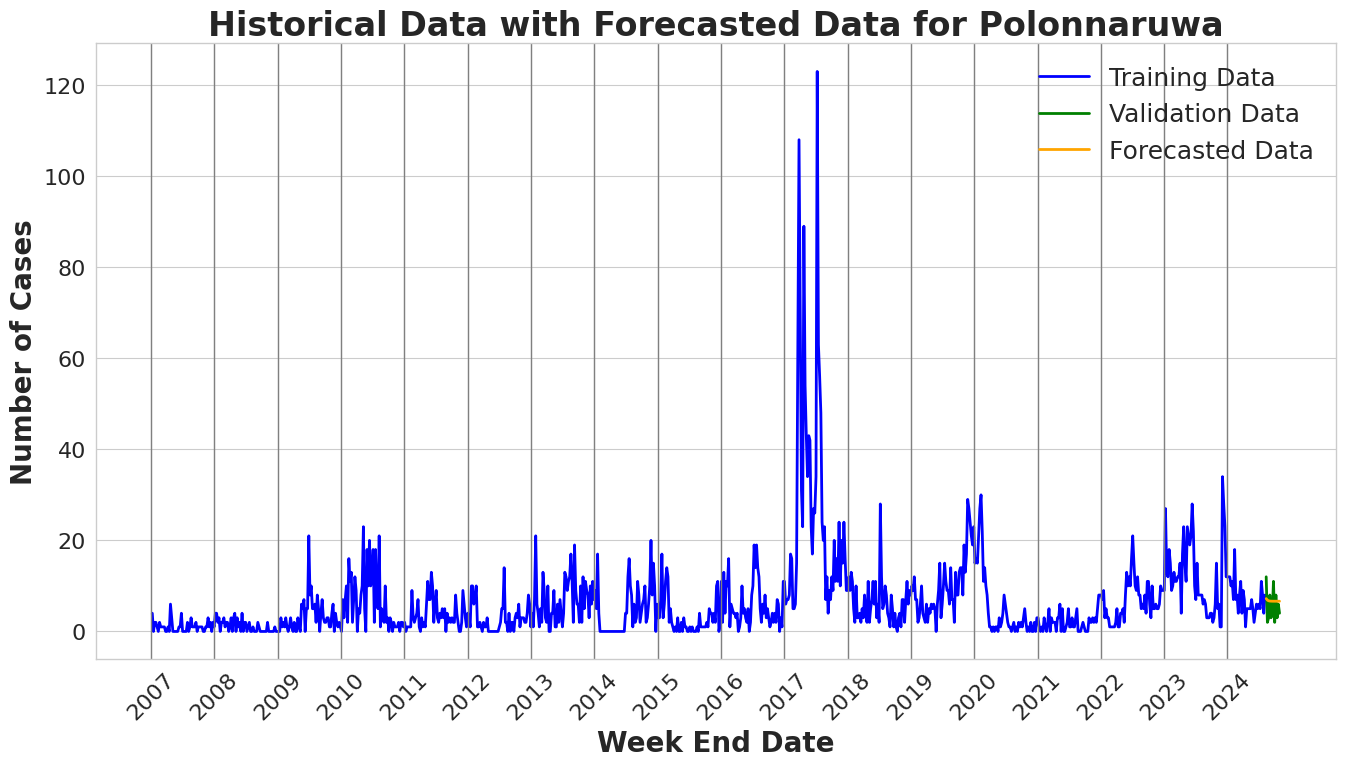

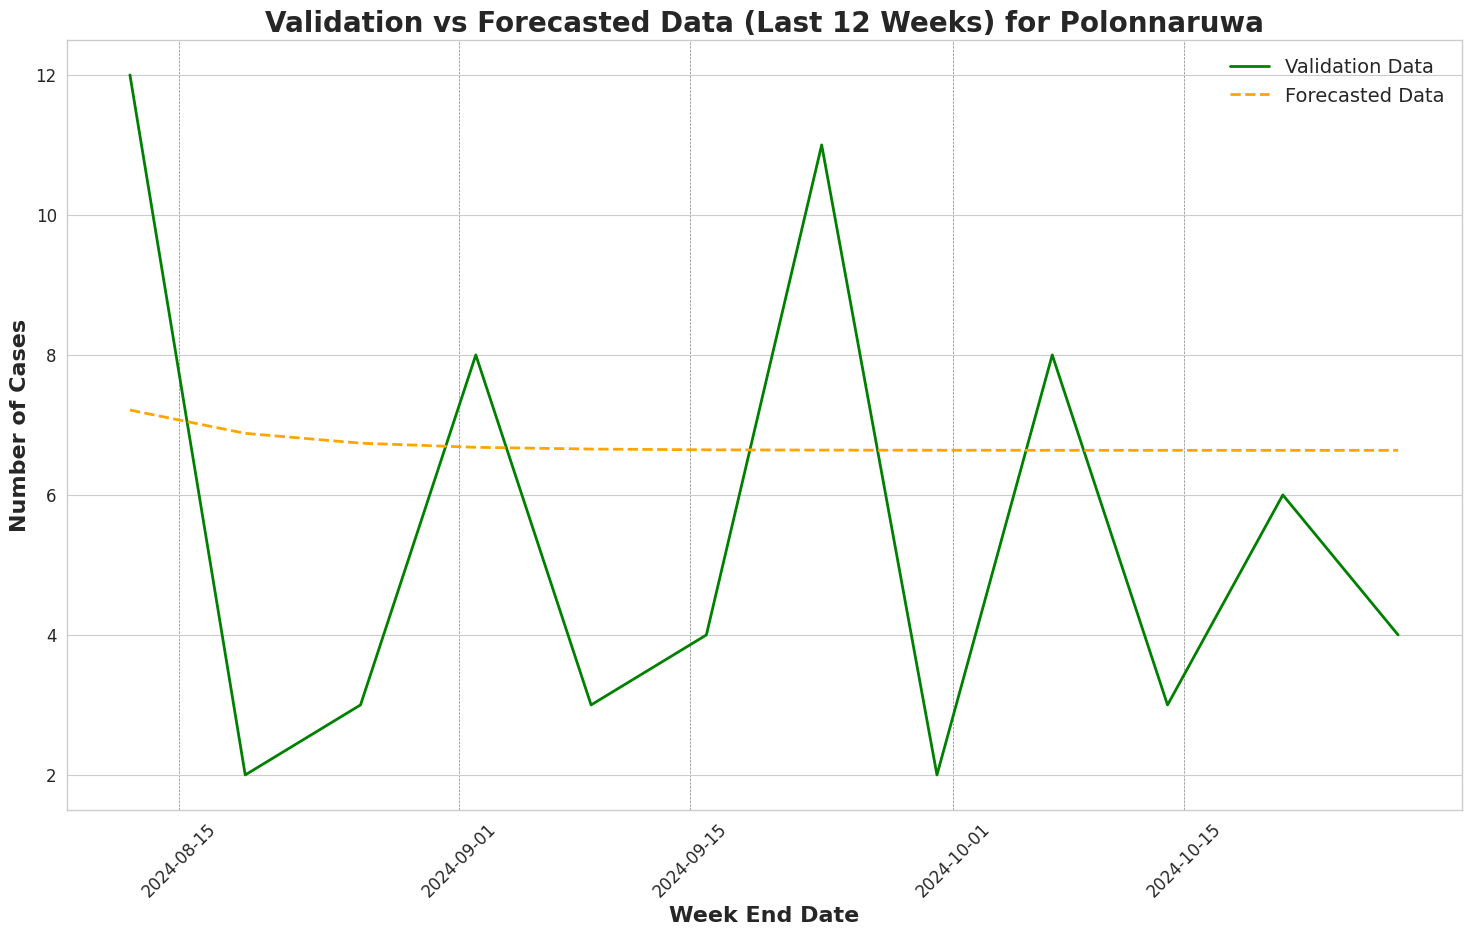

{'RMSE': 3.4854734752784875, 'MAE': 3.191542963681266, 'SMAPE': 57.542121180043324, 'RMSLE': 0.5712115284132397}
Training length for Puttalam: 918
Validation length for Puttalam: 12
Model saved for Puttalam: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Puttalam_LinearRegressionModel.pkl


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


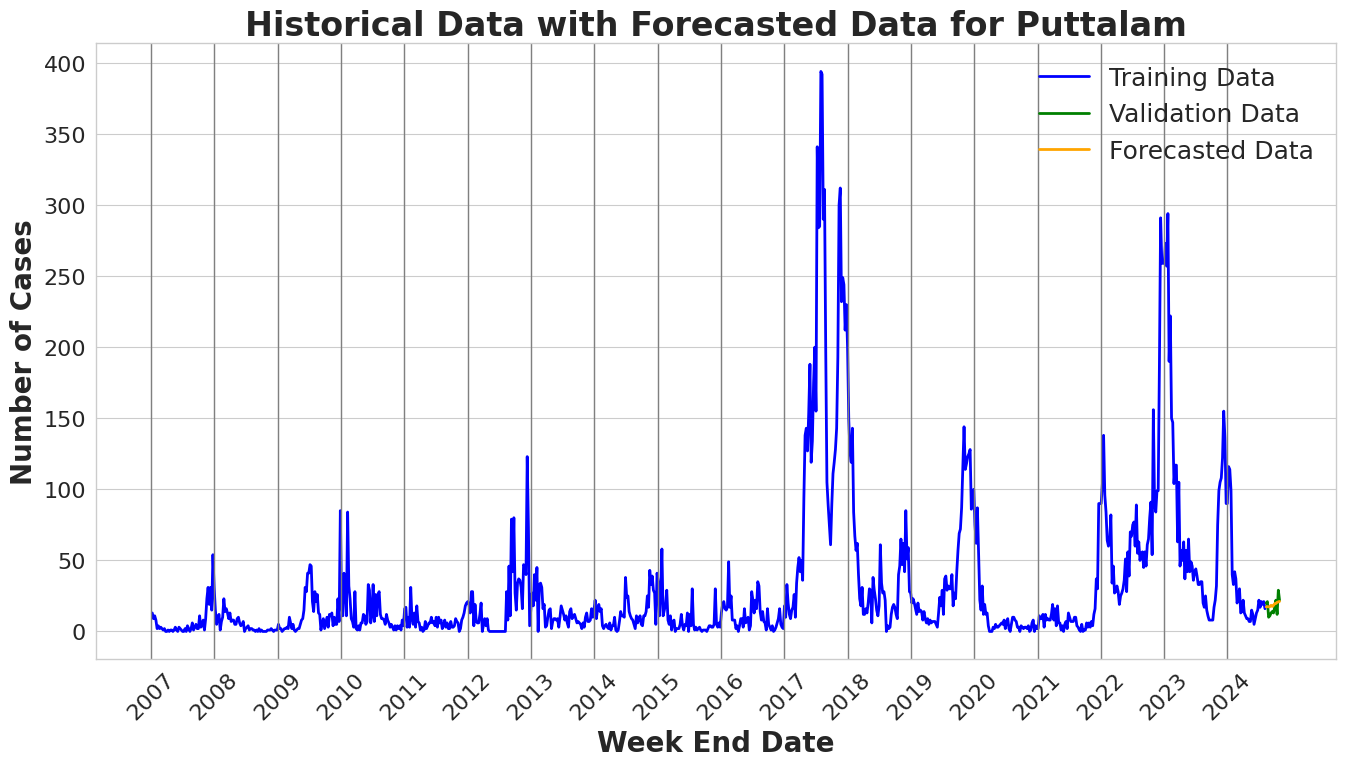

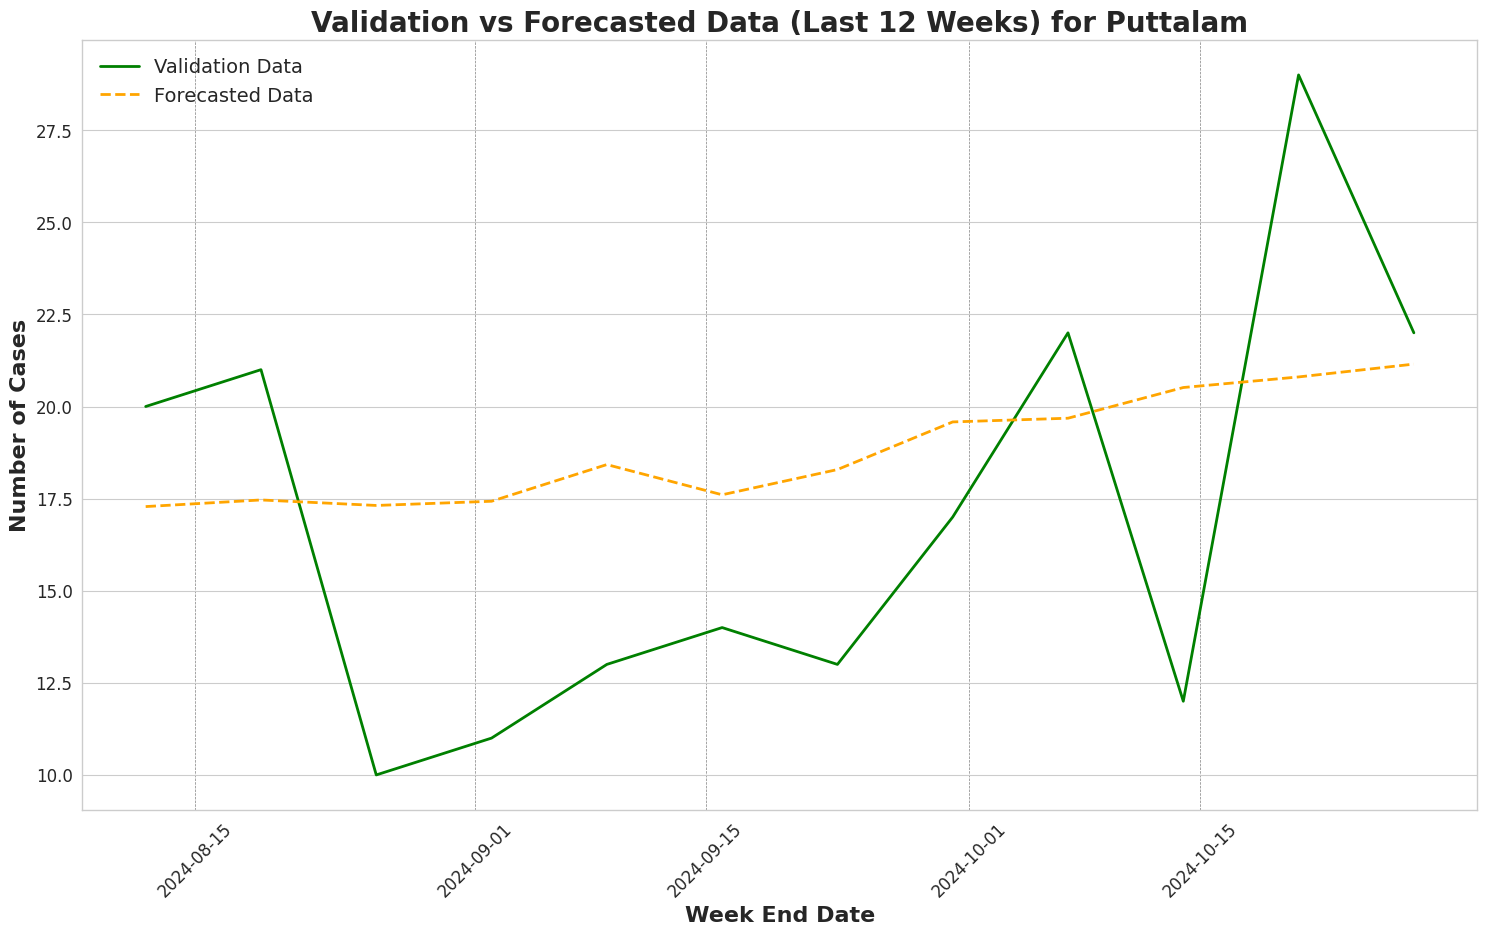

{'RMSE': 5.30375082776369, 'MAE': 4.731112112219022, 'SMAPE': 28.111964875567395, 'RMSLE': 0.3077441818364669}
Training length for Ratnapura: 918
Validation length for Ratnapura: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Ratnapura: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Ratnapura_AutoARIMA.pkl


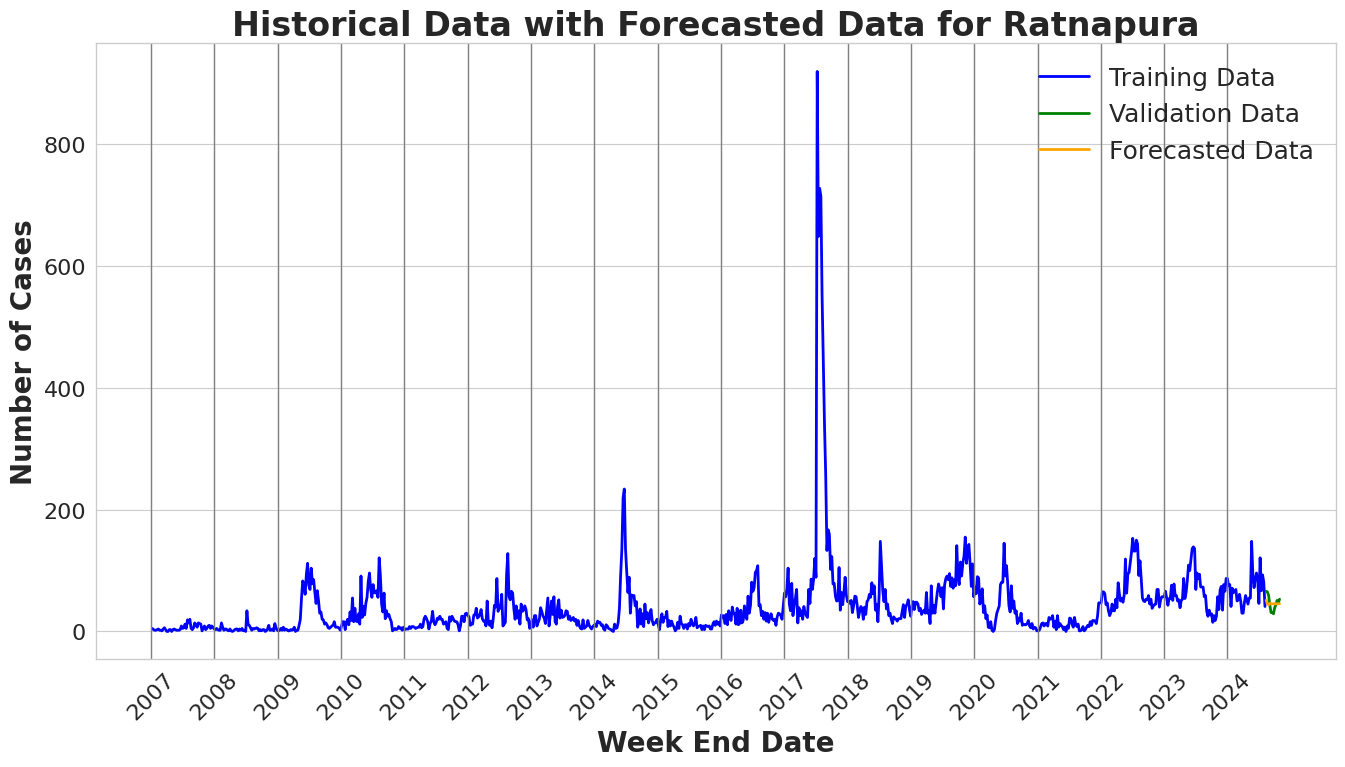

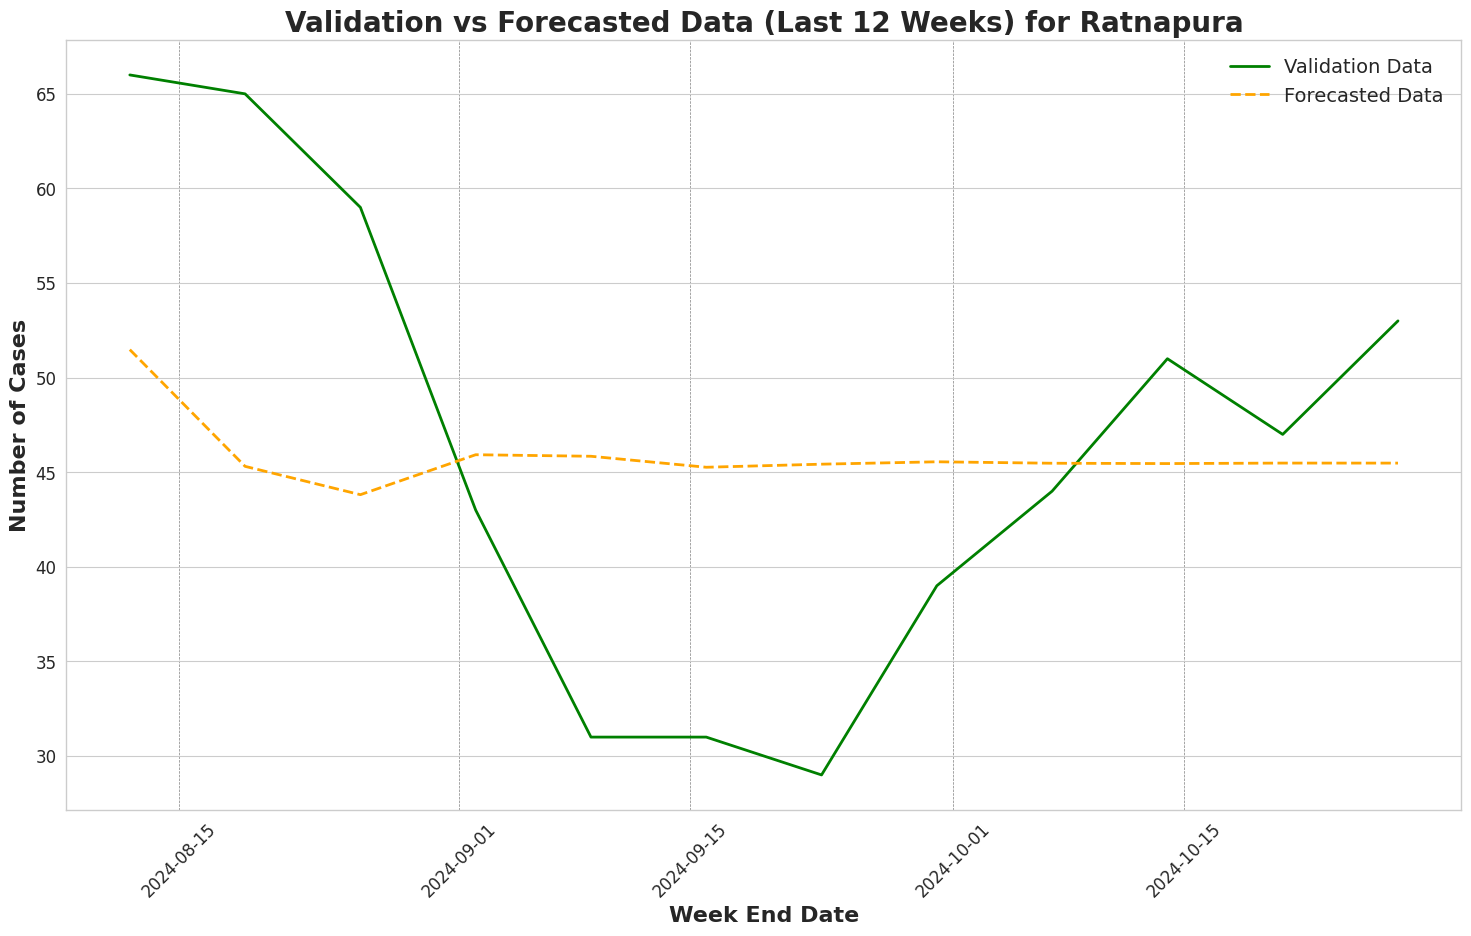

<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr98etxo/lzot8awi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr98etxo/hmf6r5jz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41671', 'data', 'file=/tmp/tmpzr98etxo/lzot8awi.json', 'init=/tmp/t

{'RMSE': 11.78250384977406, 'MAE': 10.038147833202247, 'SMAPE': 22.129268730184048, 'RMSLE': 0.25924953116846366}
Training length for Trincomalee: 918
Validation length for Trincomalee: 12


12:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model saved for Trincomalee: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Trincomalee_Prophet.pkl


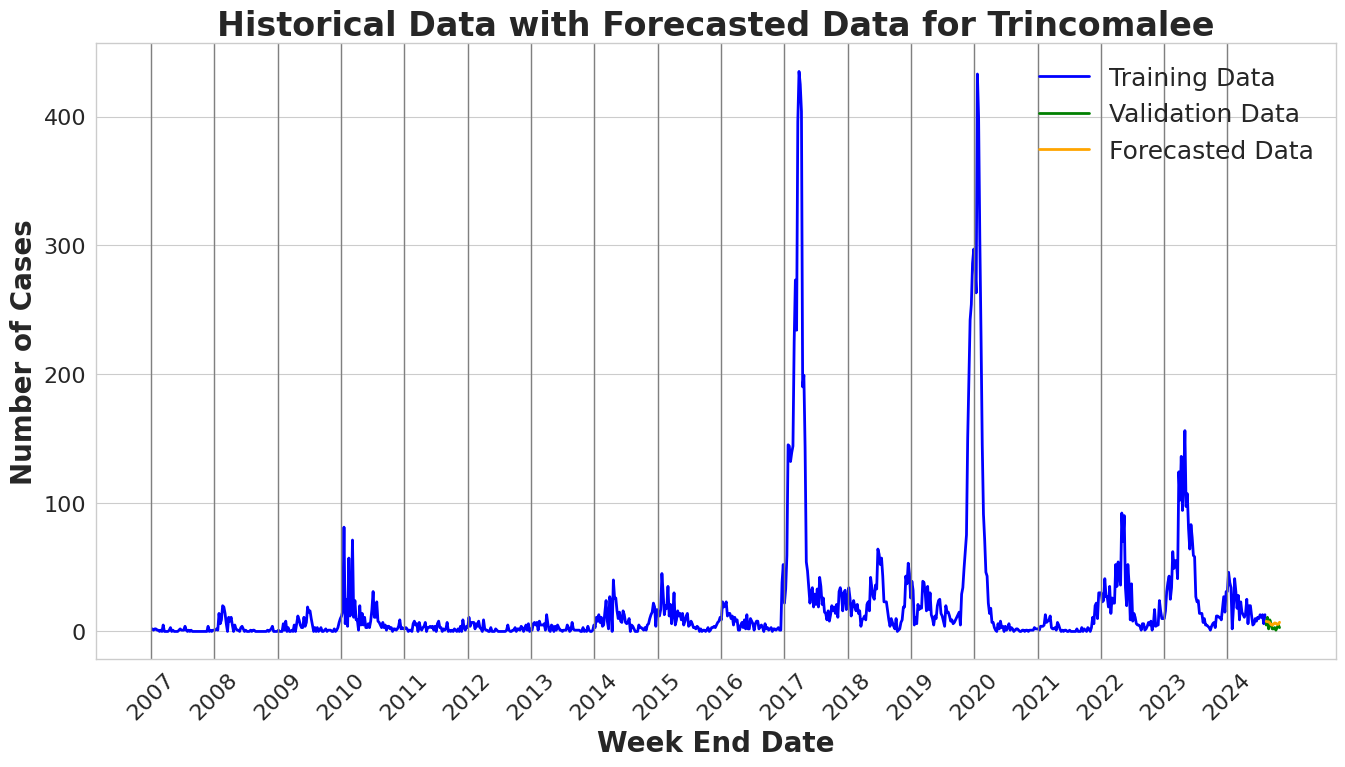

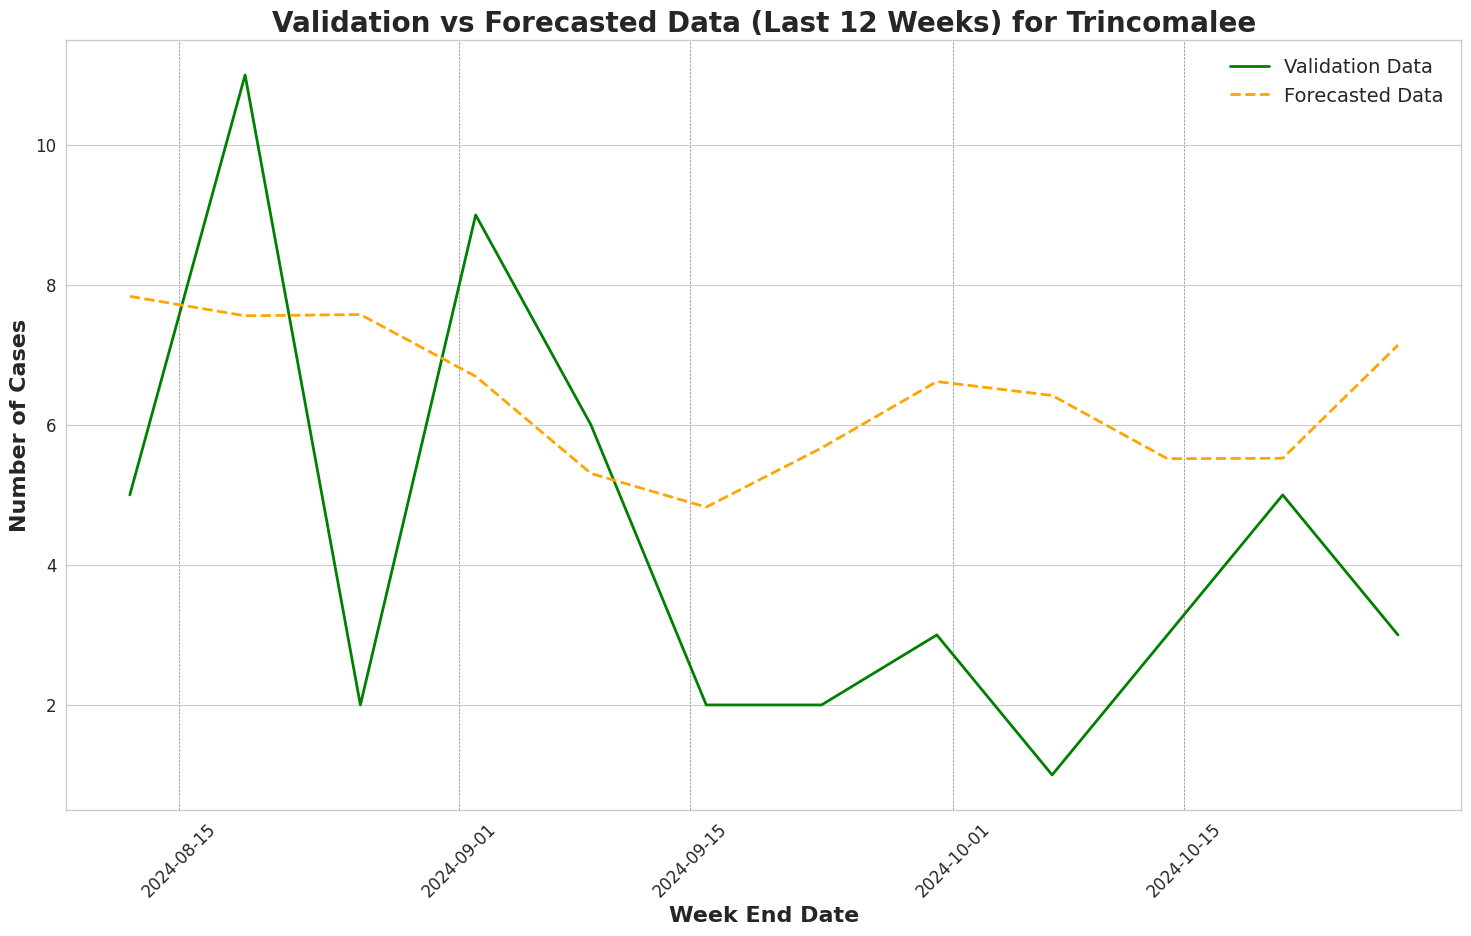

{'RMSE': 3.4701748162778197, 'MAE': 3.1312251081957077, 'SMAPE': 65.83398346919682, 'RMSLE': 0.6715202338600279}
Training length for Vavuniya: 918
Validation length for Vavuniya: 12


<ipython-input-83-d7a273e0f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Model saved for Vavuniya: /content/drive/MyDrive/Sri_Lanka_Dengue_Forecasting/Models/Vavuniya_KalmanForecaster.pkl


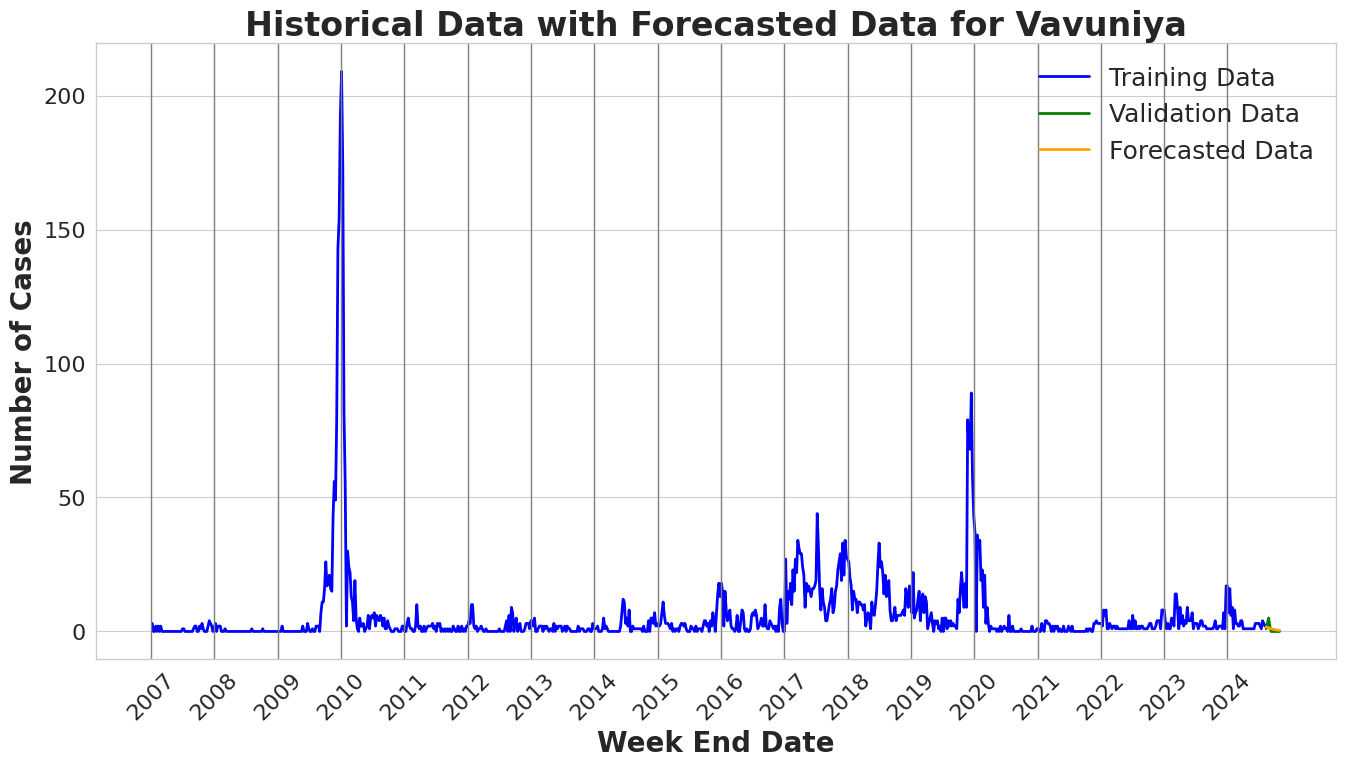

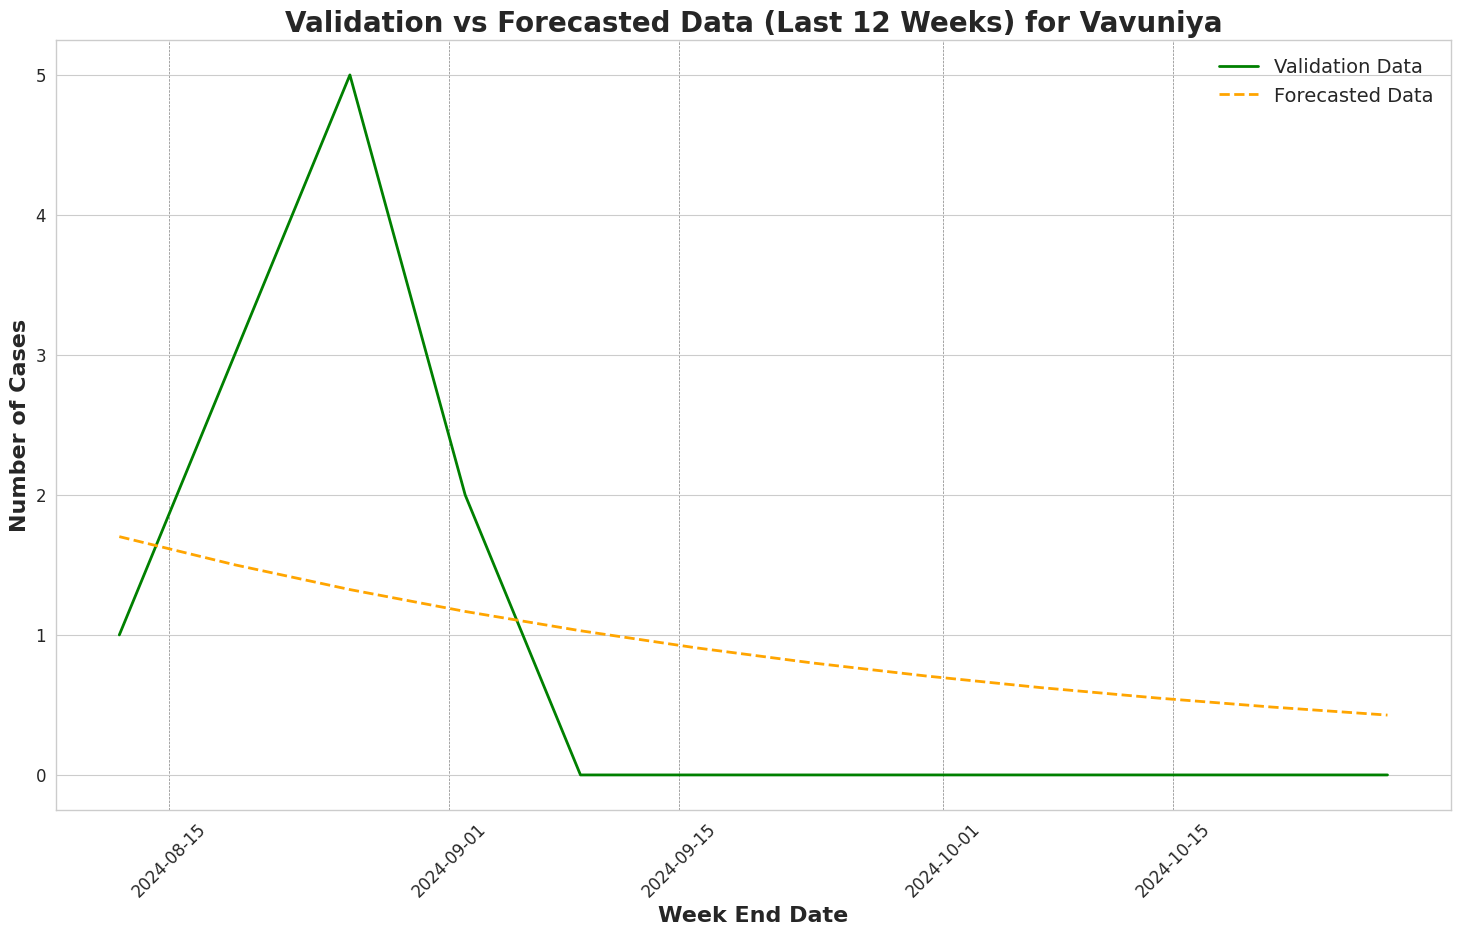

{'RMSE': 1.3253759723897491, 'MAE': 1.019988807135065, 'SMAPE': 157.28048655343255, 'RMSLE': 0.545902572586787}


In [83]:
districts = df['District'].unique()
all_results = []

for index, district in enumerate(districts):
    # Filter data for the specified district
    district_data = df[df['District'] == district]

    # Ensure the 'Week_End_Date' column is in datetime format
    district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

    # Prepare the data for ARIMA
    series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases', 'Avg Max Temp (°C)', "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Wind Speed (km/h)"])

    # Split series
    # Set aside the last 12 weeks as a validation series
    train_data, val_data = series["Number_of_Cases"][:-12], series["Number_of_Cases"][-12:]
    future_covariates = series[["Avg Max Temp (°C)", "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Wind Speed (km/h)"]]


    print(f"Training length for {district}: {len(train_data)}")
    print(f"Validation length for {district}: {len(val_data)}")

    # Train and forecast
    result = train_and_forecast(
        train_data,
        val_data,
        future_covariates,
        district_models[index],
        district
    )

    all_results.append(result)

# Create a DataFrame from results
results_df = pd.DataFrame(all_results)

## 6. Result

In [84]:
results_df.to_csv("results.csv")
print(results_df)

        District                  Model  \
0         Ampara                    FFT   
1   Anuradhapura       KalmanForecaster   
2        Badulla          CatBoostModel   
3     Batticaloa   ExponentialSmoothing   
4        Colombo           RandomForest   
5          Galle                    FFT   
6        Gampaha           RandomForest   
7     Hambantota           RandomForest   
8         Jaffna                  ARIMA   
9       Kalutara           RandomForest   
10         Kandy                  ARIMA   
11       Kegalle  LinearRegressionModel   
12   Kilinochchi   ExponentialSmoothing   
13    Kurunegala          CatBoostModel   
14        Mannar              AutoARIMA   
15        Matale           RandomForest   
16        Matara              AutoARIMA   
17    Monaragala                Prophet   
18    Mullaitivu              AutoARIMA   
19   NuwaraEliya                Prophet   
20   Polonnaruwa              AutoARIMA   
21      Puttalam  LinearRegressionModel   
22     Ratn

## 7. Conclusion
To assess each models we need to see the error metrics of each model and then we have to decide which model outperformed.

Note: `We also need to do backtesting to make sure model is performing as intended`